In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy
from scipy import signal
from scipy.fft import fft, fftfreq
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import os

In [175]:
data_path_1 = Path("datasets/1st_test")
# List files in the directory
files_1 = list(data_path_1.glob('*'))
print("Number of files in set 1:", len(files_1))

Number of files in set 1: 2156


In [176]:
first_file_path = files_1[0]
raw_data_1 = np.loadtxt(first_file_path)

print("\nShape of set 1:", raw_data_1.shape)
print("\nFirst few rows of the data:")
print(raw_data_1[:5])


Shape of set 1: (20480, 8)

First few rows of the data:
[[-0.195 -0.181 -0.178 -0.188 -0.156 -0.088 -0.117 -0.195]
 [-0.115  0.046 -0.173 -0.115 -0.146 -0.139 -0.093 -0.232]
 [-0.134 -0.059 -0.264 -0.208 -0.085  0.007 -0.034 -0.183]
 [-0.132 -0.139 -0.178 -0.183 -0.21  -0.061 -0.076 -0.151]
 [-0.2   -0.203 -0.176 -0.183 -0.088 -0.149 -0.217 -0.159]]


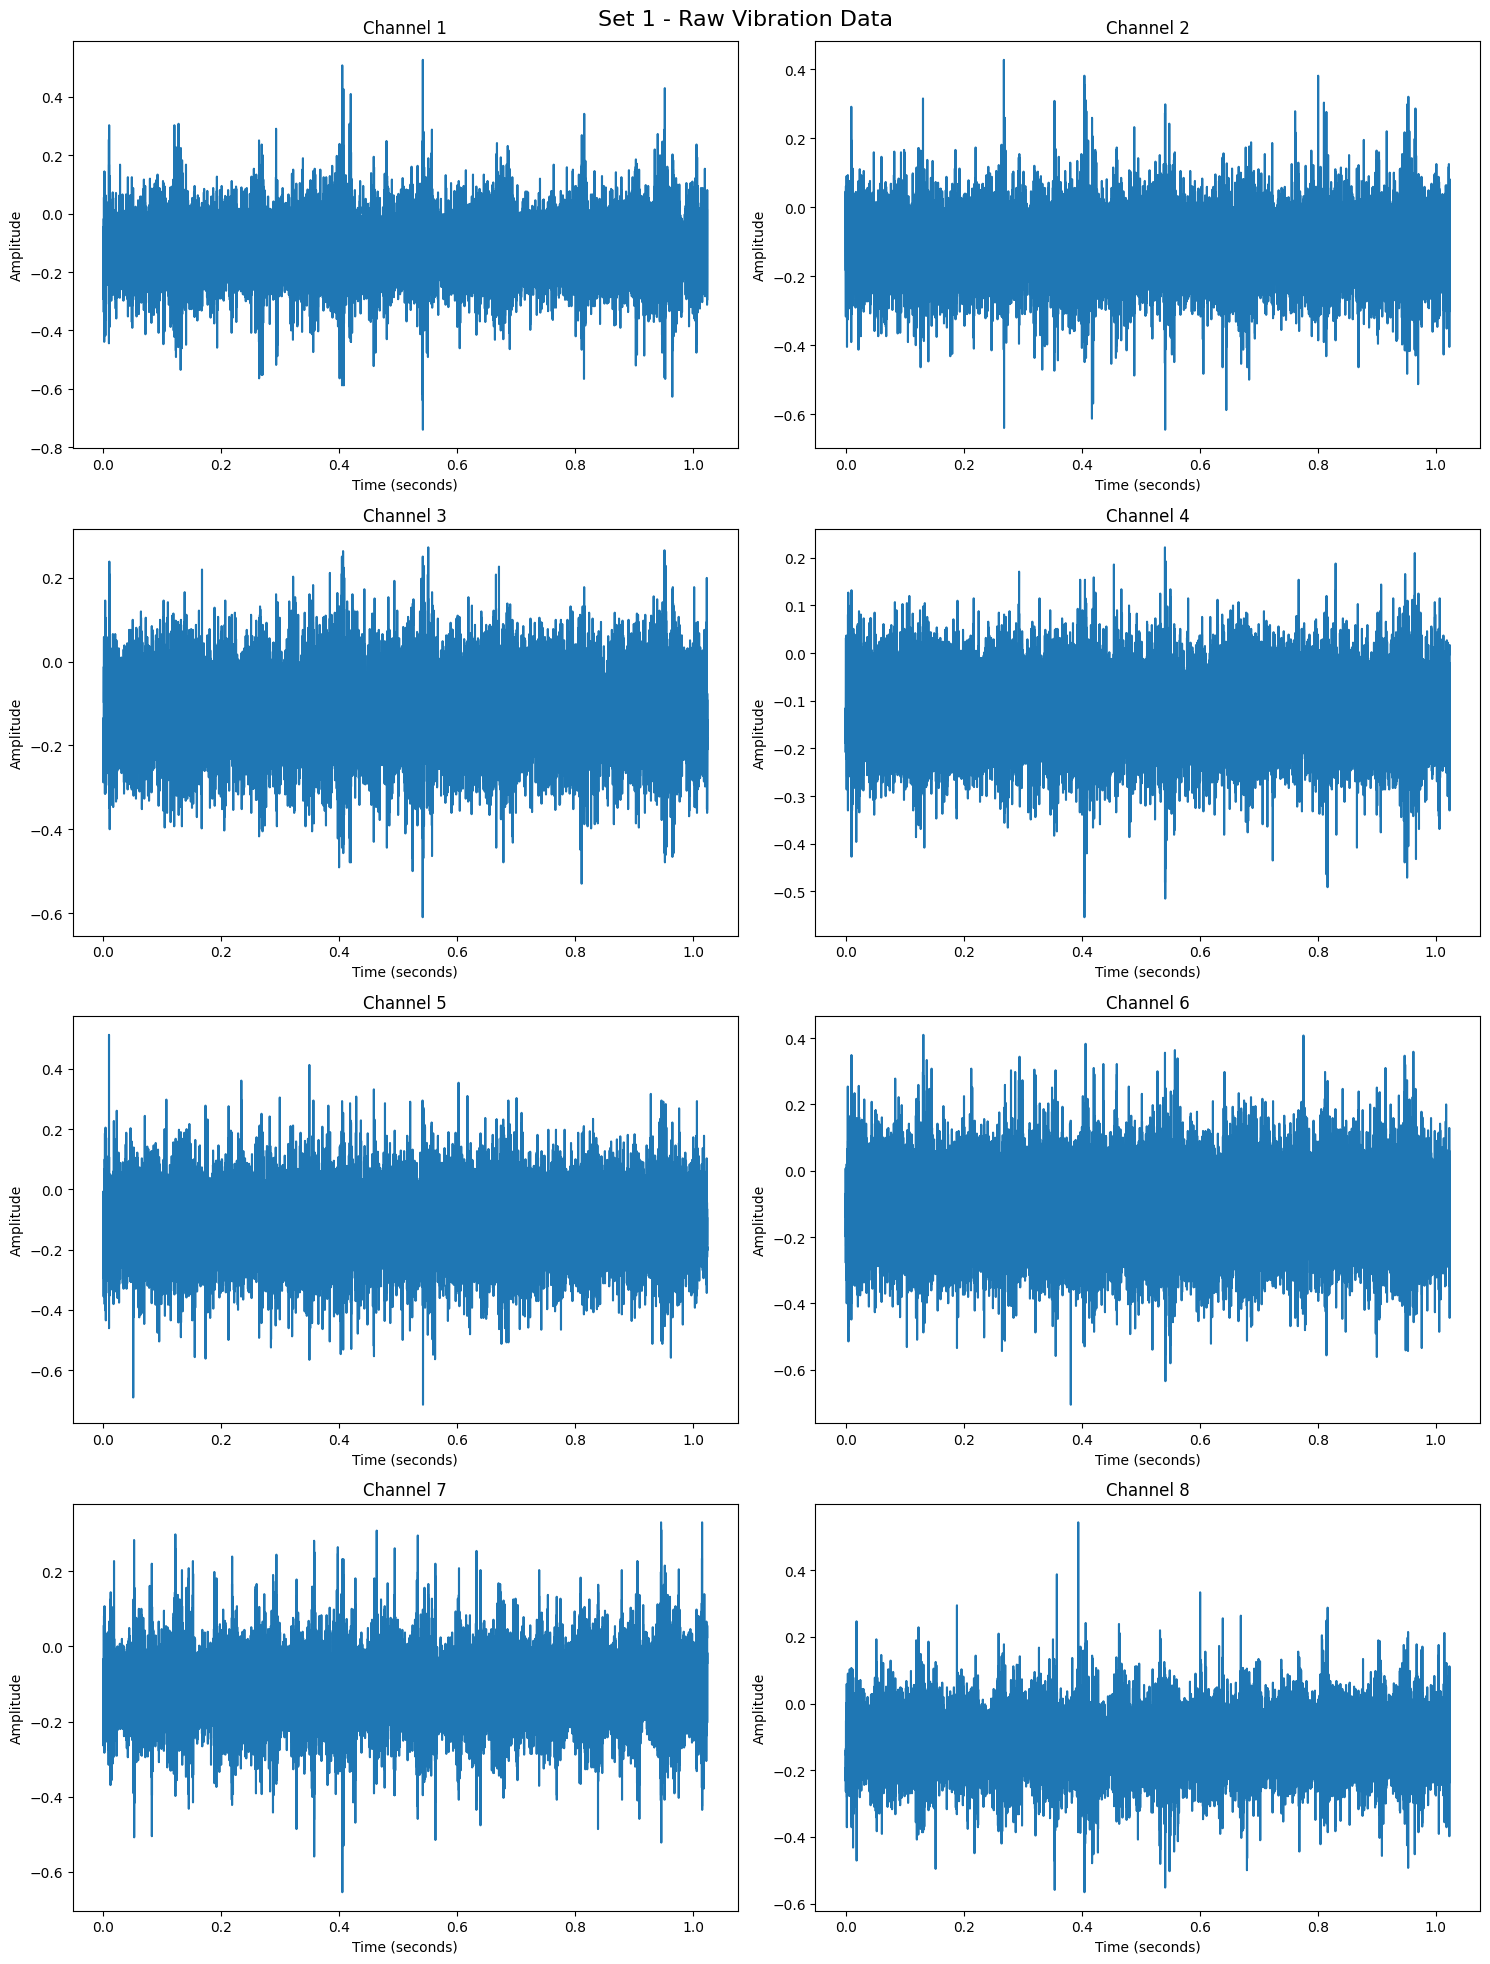

In [177]:
# Function to create time array for x-axis
def create_time_array(data_length, sampling_rate=20000):
    return np.arange(data_length) / sampling_rate

# Create plots for Set 1 (8 channels)
time = create_time_array(len(raw_data_1))
fig1, axes1 = plt.subplots(4, 2, figsize=(15, 20))
fig1.suptitle('Set 1 - Raw Vibration Data', size=16)

for i in range(4):
    for j in range(2):
        channel = i * 2 + j
        axes1[i,j].plot(time, raw_data_1[:, channel])
        axes1[i,j].set_title(f'Channel {channel + 1}')
        axes1[i,j].set_xlabel('Time (seconds)')
        axes1[i,j].set_ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [178]:
def get_bearing_statistics(data):
    stats_dict = {}

    # Get number of channels from data shape
    num_channels = data.shape[1]  # This will be 8 for Set 1, 4 for Sets 2&3

    for channel in range(num_channels):
        channel_data = data[:, channel]

        stats_dict[f'Channel_{channel+1}'] = {
            'mean': np.mean(channel_data),
            'std': np.std(channel_data),
            'max': np.max(channel_data),
            'min': np.min(channel_data),
            'rms': np.sqrt(np.mean(channel_data**2)),
            'peak_to_peak': np.max(channel_data) - np.min(channel_data)
        }

    return stats_dict

In [179]:
def process_bearing_files(data_path):
    timestamps = []
    all_stats = []

    for file in sorted(data_path.glob("*")):
        timestamps.append(file.stem)
        data = np.loadtxt(file)
        stats = get_bearing_statistics(data)  # Uses single function for all sets
        all_stats.append(stats)

    print(f"Total files processed: {len(timestamps)}")
    return timestamps, all_stats

In [180]:
timestamps_1, statistics_1 = process_bearing_files(data_path_1)

Total files processed: 2156


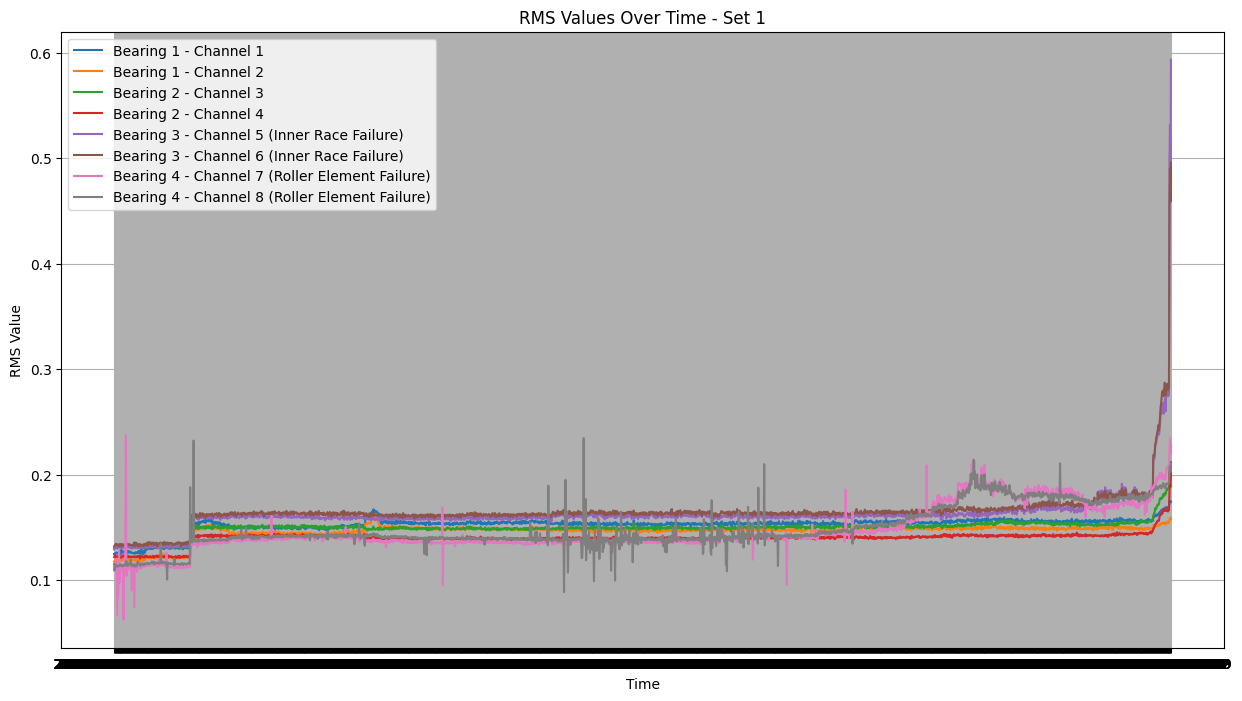

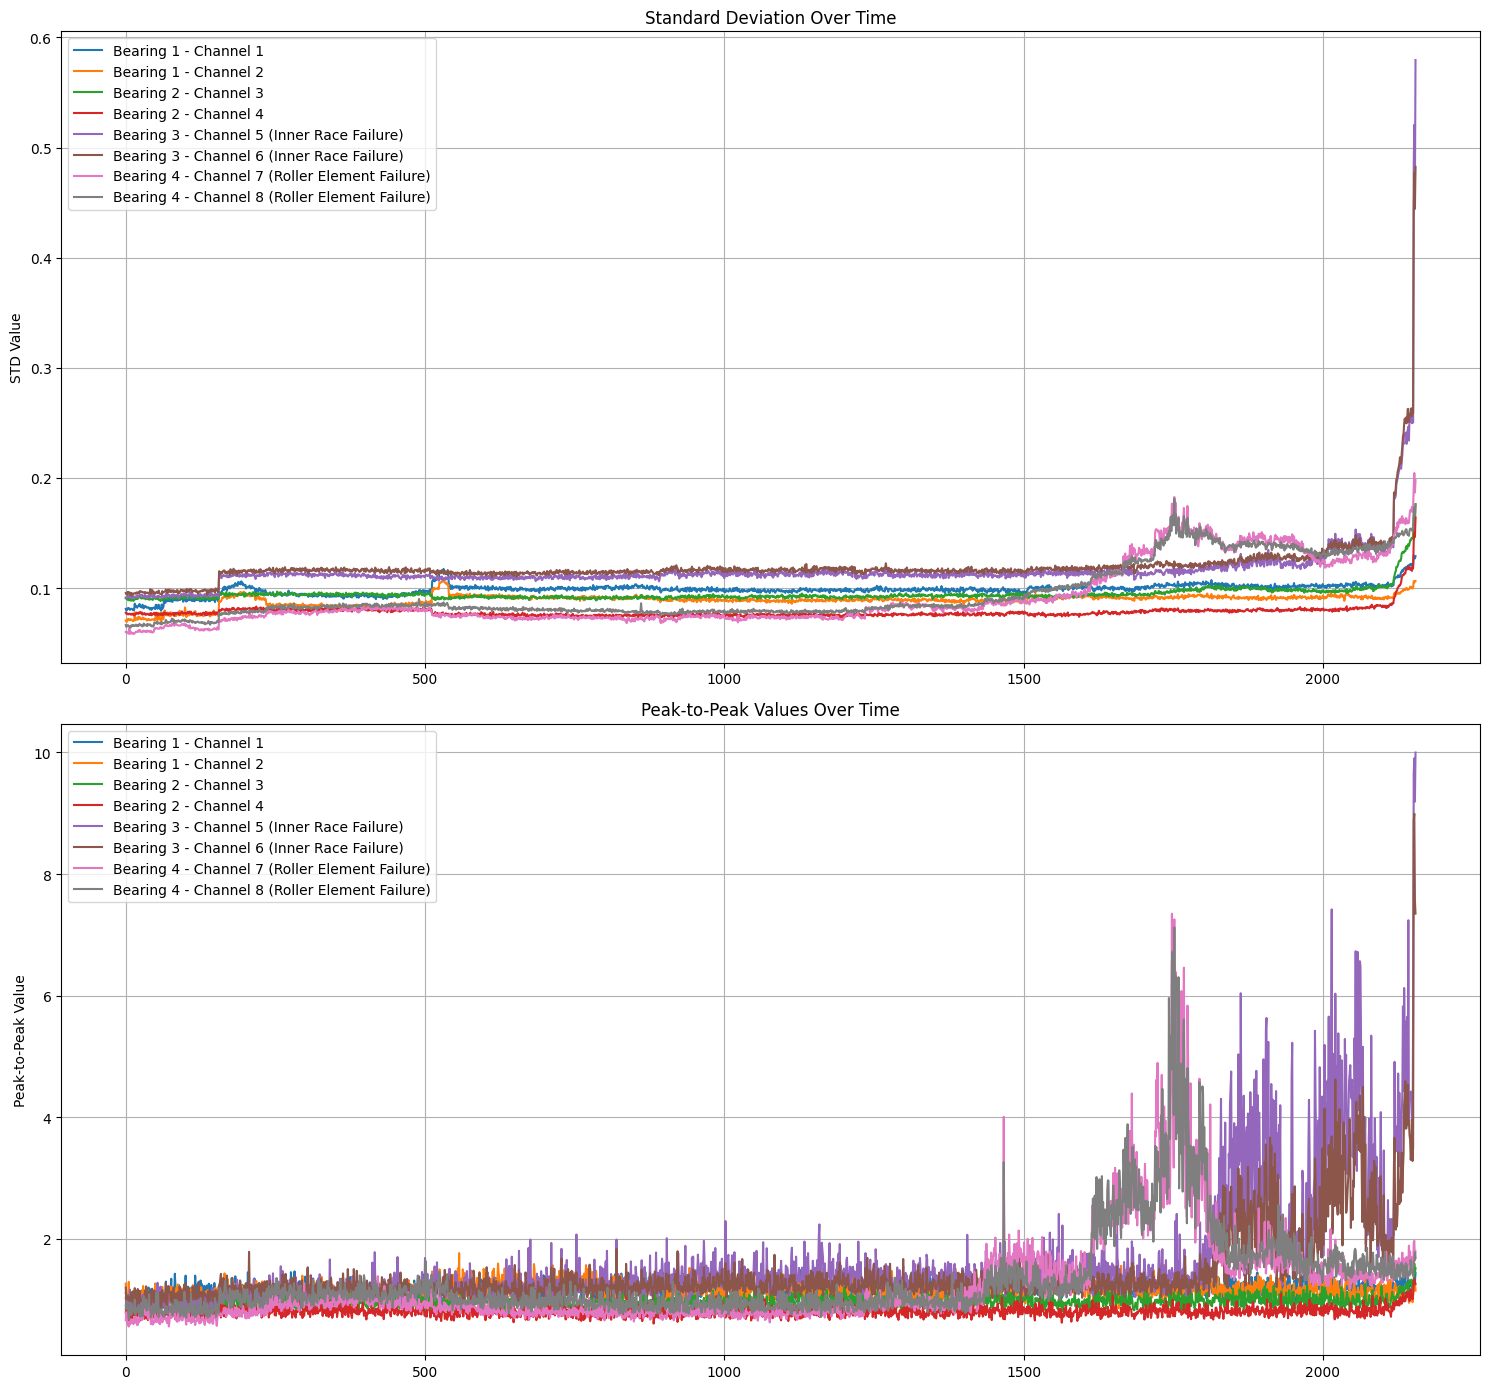

In [181]:
# Create lists to store data
times = []
bearing_stats = {
    'bearing1_ch1_rms': [], 'bearing1_ch2_rms': [],
    'bearing2_ch3_rms': [], 'bearing2_ch4_rms': [],
    'bearing3_ch5_rms': [], 'bearing3_ch6_rms': [],
    'bearing4_ch7_rms': [], 'bearing4_ch8_rms': []
}

# Extract RMS values for each channel over time
for time, stats in zip(timestamps_1, statistics_1):
    times.append(time)
    # Get RMS values for each channel of each bearing
    bearing_stats['bearing1_ch1_rms'].append(stats['Channel_1']['rms'])
    bearing_stats['bearing1_ch2_rms'].append(stats['Channel_2']['rms'])
    bearing_stats['bearing2_ch3_rms'].append(stats['Channel_3']['rms'])
    bearing_stats['bearing2_ch4_rms'].append(stats['Channel_4']['rms'])
    bearing_stats['bearing3_ch5_rms'].append(stats['Channel_5']['rms'])
    bearing_stats['bearing3_ch6_rms'].append(stats['Channel_6']['rms'])
    bearing_stats['bearing4_ch7_rms'].append(stats['Channel_7']['rms'])
    bearing_stats['bearing4_ch8_rms'].append(stats['Channel_8']['rms'])

# Create DataFrame
df_stats = pd.DataFrame(bearing_stats, index=times)

# Plot RMS trends for all channels
plt.figure(figsize=(15, 8))
plt.plot(df_stats['bearing1_ch1_rms'], label='Bearing 1 - Channel 1')
plt.plot(df_stats['bearing1_ch2_rms'], label='Bearing 1 - Channel 2')
plt.plot(df_stats['bearing2_ch3_rms'], label='Bearing 2 - Channel 3')
plt.plot(df_stats['bearing2_ch4_rms'], label='Bearing 2 - Channel 4')
plt.plot(df_stats['bearing3_ch5_rms'], label='Bearing 3 - Channel 5 (Inner Race Failure)')
plt.plot(df_stats['bearing3_ch6_rms'], label='Bearing 3 - Channel 6 (Inner Race Failure)')
plt.plot(df_stats['bearing4_ch7_rms'], label='Bearing 4 - Channel 7 (Roller Element Failure)')
plt.plot(df_stats['bearing4_ch8_rms'], label='Bearing 4 - Channel 8 (Roller Element Failure)')
plt.title('RMS Values Over Time - Set 1')
plt.xlabel('Time')
plt.ylabel('RMS Value')
plt.legend()
plt.grid(True)
plt.show()

# Create figure with 2 subplots (std and peak-to-peak)
fig, axes = plt.subplots(2, 1, figsize=(15, 14))

# --- Standard Deviation ---
# Extracting std values for all 8 channels
bearing_std = {
    'bearing1_ch1_std': [stats['Channel_1']['std'] for stats in statistics_1],
    'bearing1_ch2_std': [stats['Channel_2']['std'] for stats in statistics_1],
    'bearing2_ch3_std': [stats['Channel_3']['std'] for stats in statistics_1],
    'bearing2_ch4_std': [stats['Channel_4']['std'] for stats in statistics_1],
    'bearing3_ch5_std': [stats['Channel_5']['std'] for stats in statistics_1],
    'bearing3_ch6_std': [stats['Channel_6']['std'] for stats in statistics_1],
    'bearing4_ch7_std': [stats['Channel_7']['std'] for stats in statistics_1],
    'bearing4_ch8_std': [stats['Channel_8']['std'] for stats in statistics_1]
}

# Plotting std values
axes[0].plot(bearing_std['bearing1_ch1_std'], label='Bearing 1 - Channel 1')
axes[0].plot(bearing_std['bearing1_ch2_std'], label='Bearing 1 - Channel 2')
axes[0].plot(bearing_std['bearing2_ch3_std'], label='Bearing 2 - Channel 3')
axes[0].plot(bearing_std['bearing2_ch4_std'], label='Bearing 2 - Channel 4')
axes[0].plot(bearing_std['bearing3_ch5_std'], label='Bearing 3 - Channel 5 (Inner Race Failure)')
axes[0].plot(bearing_std['bearing3_ch6_std'], label='Bearing 3 - Channel 6 (Inner Race Failure)')
axes[0].plot(bearing_std['bearing4_ch7_std'], label='Bearing 4 - Channel 7 (Roller Element Failure)')
axes[0].plot(bearing_std['bearing4_ch8_std'], label='Bearing 4 - Channel 8 (Roller Element Failure)')
axes[0].set_title('Standard Deviation Over Time')
axes[0].set_ylabel('STD Value')
axes[0].grid(True)
axes[0].legend()

# --- Peak-to-Peak ---
# Extracting peak-to-peak values for all 8 channels
bearing_p2p = {
    'bearing1_ch1_p2p': [stats['Channel_1']['peak_to_peak'] for stats in statistics_1],
    'bearing1_ch2_p2p': [stats['Channel_2']['peak_to_peak'] for stats in statistics_1],
    'bearing2_ch3_p2p': [stats['Channel_3']['peak_to_peak'] for stats in statistics_1],
    'bearing2_ch4_p2p': [stats['Channel_4']['peak_to_peak'] for stats in statistics_1],
    'bearing3_ch5_p2p': [stats['Channel_5']['peak_to_peak'] for stats in statistics_1],
    'bearing3_ch6_p2p': [stats['Channel_6']['peak_to_peak'] for stats in statistics_1],
    'bearing4_ch7_p2p': [stats['Channel_7']['peak_to_peak'] for stats in statistics_1],
    'bearing4_ch8_p2p': [stats['Channel_8']['peak_to_peak'] for stats in statistics_1]
}

# Plotting peak-to-peak values
axes[1].plot(bearing_p2p['bearing1_ch1_p2p'], label='Bearing 1 - Channel 1')
axes[1].plot(bearing_p2p['bearing1_ch2_p2p'], label='Bearing 1 - Channel 2')
axes[1].plot(bearing_p2p['bearing2_ch3_p2p'], label='Bearing 2 - Channel 3')
axes[1].plot(bearing_p2p['bearing2_ch4_p2p'], label='Bearing 2 - Channel 4')
axes[1].plot(bearing_p2p['bearing3_ch5_p2p'], label='Bearing 3 - Channel 5 (Inner Race Failure)')
axes[1].plot(bearing_p2p['bearing3_ch6_p2p'], label='Bearing 3 - Channel 6 (Inner Race Failure)')
axes[1].plot(bearing_p2p['bearing4_ch7_p2p'], label='Bearing 4 - Channel 7 (Roller Element Failure)')
axes[1].plot(bearing_p2p['bearing4_ch8_p2p'], label='Bearing 4 - Channel 8 (Roller Element Failure)')
axes[1].set_title('Peak-to-Peak Values Over Time')
axes[1].set_ylabel('Peak-to-Peak Value')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


In [182]:
def analyze_all_bearings(statistics, set_num):
    """
    Analyze all bearings in a dataset, both healthy and failed.
    """
    print(f"\n=== Analysis for Set {set_num} ===")

    # Number of bearings in each set
    num_bearings = 4

    failed_bearings = {
        1: [3, 4],    # Set 1: Bearings 3 and 4 failed
        2: [1],       # Set 2: Bearing 1 failed
        3: [3]        # Set 3: Bearing 3 failed
    }

    for bearing_num in range(1, num_bearings + 1):
        if set_num == 1:
            channels = [f'Channel_{2*bearing_num-1}', f'Channel_{2*bearing_num}']
        else:
            channels = [f'Channel_{bearing_num}']

        rms_values = []
        p2p_values = []
        std_values = []

        for stats in statistics:
            bearing_rms = np.mean([stats[ch]['rms'] for ch in channels])
            bearing_p2p = np.mean([stats[ch]['peak_to_peak'] for ch in channels])
            bearing_std = np.mean([stats[ch]['std'] for ch in channels])  # Added STD
            rms_values.append(bearing_rms)
            p2p_values.append(bearing_p2p)
            std_values.append(bearing_std)

        # Calculate metrics
        baseline_rms = np.mean(rms_values[:100])
        baseline_p2p = np.mean(p2p_values[:100])
        baseline_std = np.mean(std_values[:100])

        last_segment = int(len(rms_values) * 0.1)
        max_rms = max(rms_values[-last_segment:])
        max_p2p = max(p2p_values[-last_segment:])
        max_std = max(std_values[-last_segment:])

        status = "FAILED" if bearing_num in failed_bearings.get(set_num, []) else "HEALTHY"
        print(f"\nBearing {bearing_num} - {status}")
        print(f"Baseline RMS: {baseline_rms:.4f}")
        print(f"Maximum RMS: {max_rms:.4f}")
        print(f"RMS Increase: {(max_rms/baseline_rms - 1)*100:.1f}%")
        print(f"Baseline STD: {baseline_std:.4f}")
        print(f"Maximum STD: {max_std:.4f}")
        print(f"STD Increase: {(max_std/baseline_std - 1)*100:.1f}%")
        print(f"Baseline Peak-to-Peak: {baseline_p2p:.4f}")
        print(f"Maximum Peak-to-Peak: {max_p2p:.4f}")
        print(f"Peak-to-Peak Increase: {(max_p2p/baseline_p2p - 1)*100:.1f}%")

# Analyze all bearings in each set
analyze_all_bearings(statistics_1, 1)


=== Analysis for Set 1 ===

Bearing 1 - HEALTHY
Baseline RMS: 0.1239
Maximum RMS: 0.1664
RMS Increase: 34.4%
Baseline STD: 0.0791
Maximum STD: 0.1180
STD Increase: 49.1%
Baseline Peak-to-Peak: 1.0359
Maximum Peak-to-Peak: 1.3565
Peak-to-Peak Increase: 31.0%

Bearing 2 - HEALTHY
Baseline RMS: 0.1267
Maximum RMS: 0.2067
RMS Increase: 63.2%
Baseline STD: 0.0836
Maximum STD: 0.1701
STD Increase: 103.5%
Baseline Peak-to-Peak: 0.8370
Maximum Peak-to-Peak: 1.4700
Peak-to-Peak Increase: 75.6%

Bearing 3 - FAILED
Baseline RMS: 0.1324
Maximum RMS: 0.5448
RMS Increase: 311.4%
Baseline STD: 0.0944
Maximum STD: 0.5309
STD Increase: 462.2%
Baseline Peak-to-Peak: 0.9945
Maximum Peak-to-Peak: 9.4470
Peak-to-Peak Increase: 850.0%

Bearing 4 - FAILED
Baseline RMS: 0.1136
Maximum RMS: 0.2214
RMS Increase: 94.9%
Baseline STD: 0.0654
Maximum STD: 0.1889
STD Increase: 189.0%
Baseline Peak-to-Peak: 0.7759
Maximum Peak-to-Peak: 1.9875
Peak-to-Peak Increase: 156.2%


In [183]:
def calculate_bearing_health_score(baseline_rms, current_rms, baseline_p2p, current_p2p):
    """
    Calculate a health score (0-100) for a bearing based on our findings:
    - 100: Perfect health
    - 70-100: Normal operation
    - 40-70: Watch closely
    - Below 40: Critical
    """
    # Calculate percentage increases
    rms_increase = (current_rms / baseline_rms - 1) * 100
    p2p_increase = (current_p2p / baseline_p2p - 1) * 100

    # Convert to a 0-100 score based on our findings from healthy vs failed bearings
    rms_score = max(0, min(100, 100 - (rms_increase / 3)))  # 300% increase -> score of 0
    p2p_score = max(0, min(100, 100 - (p2p_increase / 8)))  # 800% increase -> score of 0

    # Combine scores (weighted towards Peak-to-Peak as it's more sensitive)
    final_score = round(0.4 * rms_score + 0.6 * p2p_score)

    # Determine status
    if final_score >= 70:
        status = "HEALTHY"
    elif final_score >= 40:
        status = "WARNING"
    else:
        status = "CRITICAL"

    return final_score, status


In [184]:
def analyze_bearing_health_trends(statistics, set_num, bearing_num):
    """
    Analyze bearing health trends with special handling for different failure types.
    Takes full timeline into account for roller element failure detection.
    """
    # Get channels based on dataset
    if set_num == 1:
        channels = [f'Channel_{2*bearing_num-1}', f'Channel_{2*bearing_num}']
    else:
        channels = [f'Channel_{bearing_num}']

    # Calculate baseline from first 100 readings
    baseline_rms = np.mean([np.mean([stats[ch]['rms'] for ch in channels])
                           for stats in statistics[:100]])
    baseline_p2p = np.mean([np.mean([stats[ch]['peak_to_peak'] for ch in channels])
                           for stats in statistics[:100]])

    # Calculate scores over time
    scores = []
    for stats in statistics:
        current_rms = np.mean([stats[ch]['rms'] for ch in channels])
        current_p2p = np.mean([stats[ch]['peak_to_peak'] for ch in channels])
        score, status = calculate_bearing_health_score(baseline_rms, current_rms,
                                                     baseline_p2p, current_p2p)
        scores.append(score)

    # Get initial score
    initial_score = scores[0]

    # Special handling for roller element failure
    if set_num == 1 and bearing_num == 4:
        # Look at full timeline for roller element failure
        worst_score = min(scores)
        worst_index = scores.index(worst_score)
        print(f"Roller Element Failure detected at file {worst_index}")
        print(f"Percentage through lifetime: {(worst_index/len(scores))*100:.1f}%")
    else:
        # Use last 10% for other bearings
        worst_score = min(scores[-int(len(scores)*0.1):])

    # Once a bearing hits critical, it stays critical
    if worst_score < 40:
        final_score = worst_score
    else:
        final_score = scores[-1]

    return initial_score, worst_score, final_score

# Analyze all failing bearings
print("=== Bearing Health Analysis ===")

# Set 1 failing bearings
print("\nSet 1, Bearing 3 (Inner Race):")
initial, worst, final = analyze_bearing_health_trends(statistics_1, 1, 3)
print(f"Initial Health: {initial}")
print(f"Worst Health: {worst}")
print(f"Final Health: {final}")
if worst < 40:
    condition = "CRITICAL FAILURE"
elif worst < 70:
    condition = "WARNING LEVEL"
else:
    condition = "MODERATE WEAR"
print(f"Condition Assessment: {condition}")

print("\nSet 1, Bearing 4 (Roller Element):")
initial, worst, final = analyze_bearing_health_trends(statistics_1, 1, 4)
print(f"Initial Health: {initial}")
print(f"Worst Health: {worst}")
print(f"Final Health: {final}")
if worst < 40:
    condition = "CRITICAL FAILURE"
elif worst < 70:
    condition = "WARNING LEVEL"
else:
    condition = "MODERATE WEAR"
print(f"Condition Assessment: {condition}")

=== Bearing Health Analysis ===

Set 1, Bearing 3 (Inner Race):
Initial Health: 100
Worst Health: 2
Final Health: 2
Condition Assessment: CRITICAL FAILURE

Set 1, Bearing 4 (Roller Element):
Roller Element Failure detected at file 1752
Percentage through lifetime: 81.3%
Initial Health: 100
Worst Health: 28
Final Health: 28
Condition Assessment: CRITICAL FAILURE


In [185]:
def load_bearing_file(file_path):
    """Load single bearing data file"""
    return np.loadtxt(file_path)

In [186]:
def analyze_frequency_components(data, set_num, bearing_num, channel, sampling_rate=20000):
    """
    Analyze frequency components of bearing vibration data.

    Args:
        data: Raw vibration data array
        set_num: Test set number (1-3)
        bearing_num: Bearing number in the set (1-4)
        channel: Channel number to analyze (0-7 for Set 1, 0-3 for Sets 2&3)
        sampling_rate: Data collection rate (Hz)
    """
    # Extract single channel data
    channel_data = data[:, channel]

    # Calculate FFT
    n = len(channel_data)
    fft_result = fft(channel_data)

    # Get frequencies corresponding to FFT results
    freq = fftfreq(n, 1/sampling_rate)

    # Calculate magnitude spectrum
    magnitude = 2.0/n * np.abs(fft_result[0:n//2])
    freq = freq[0:n//2]

    # Plot time domain and frequency domain
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Time domain plot
    time = np.arange(n) / sampling_rate
    ax1.plot(time, channel_data)
    ax1.set_title(f'Time Domain Signal - Set {set_num} Bearing {bearing_num} Channel {channel+1}')
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('Amplitude')

    # Frequency domain plot
    ax2.plot(freq, magnitude)
    ax2.set_title(f'Frequency Spectrum - Set {set_num} Bearing {bearing_num} Channel {channel+1}')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.set_xlim(0, 5000)

    plt.tight_layout()
    return freq, magnitude

=== Set 1 Analysis ===

Analysis for Bearing 3:
Failure detected at file 2152/2156 (99.8%)

Channel 5 Changes:
Peak Magnitude Change: 24.6%
Mean Magnitude Change: 394.8%
Total Energy Change: 394.8%

Frequency Band Changes:
low_band_change: 195.1%
mid_band_change: 379.5%
high_band_change: 561.0%

Channel 6 Changes:
Peak Magnitude Change: 23.2%
Mean Magnitude Change: 335.8%
Total Energy Change: 335.8%

Frequency Band Changes:
low_band_change: 256.3%
mid_band_change: 385.9%
high_band_change: 486.2%

Analysis for Bearing 4:
Failure detected at file 1752/2156 (81.3%)

Channel 7 Changes:
Peak Magnitude Change: 23.8%
Mean Magnitude Change: 200.8%
Total Energy Change: 200.8%

Frequency Band Changes:
low_band_change: 101.2%
mid_band_change: 349.6%
high_band_change: 211.4%

Channel 8 Changes:
Peak Magnitude Change: 20.8%
Mean Magnitude Change: 168.9%
Total Energy Change: 168.9%

Frequency Band Changes:
low_band_change: 126.6%
mid_band_change: 304.7%
high_band_change: 196.8%


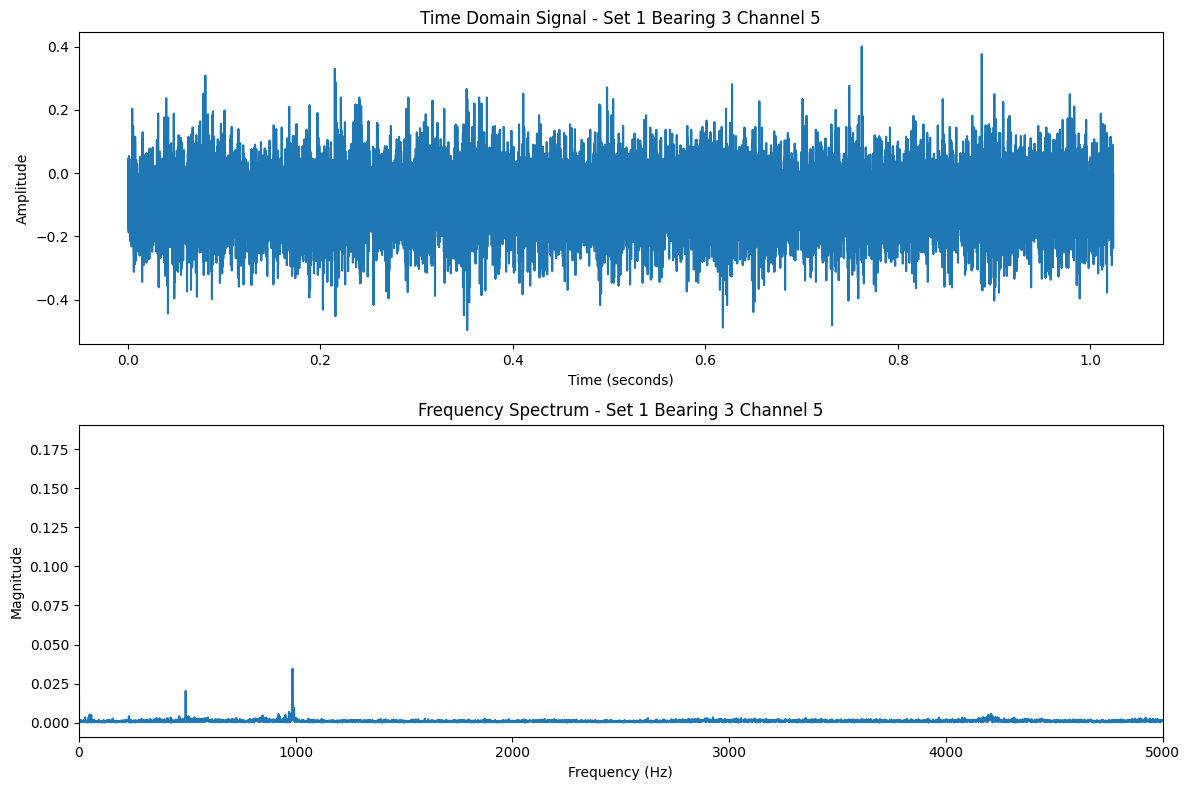

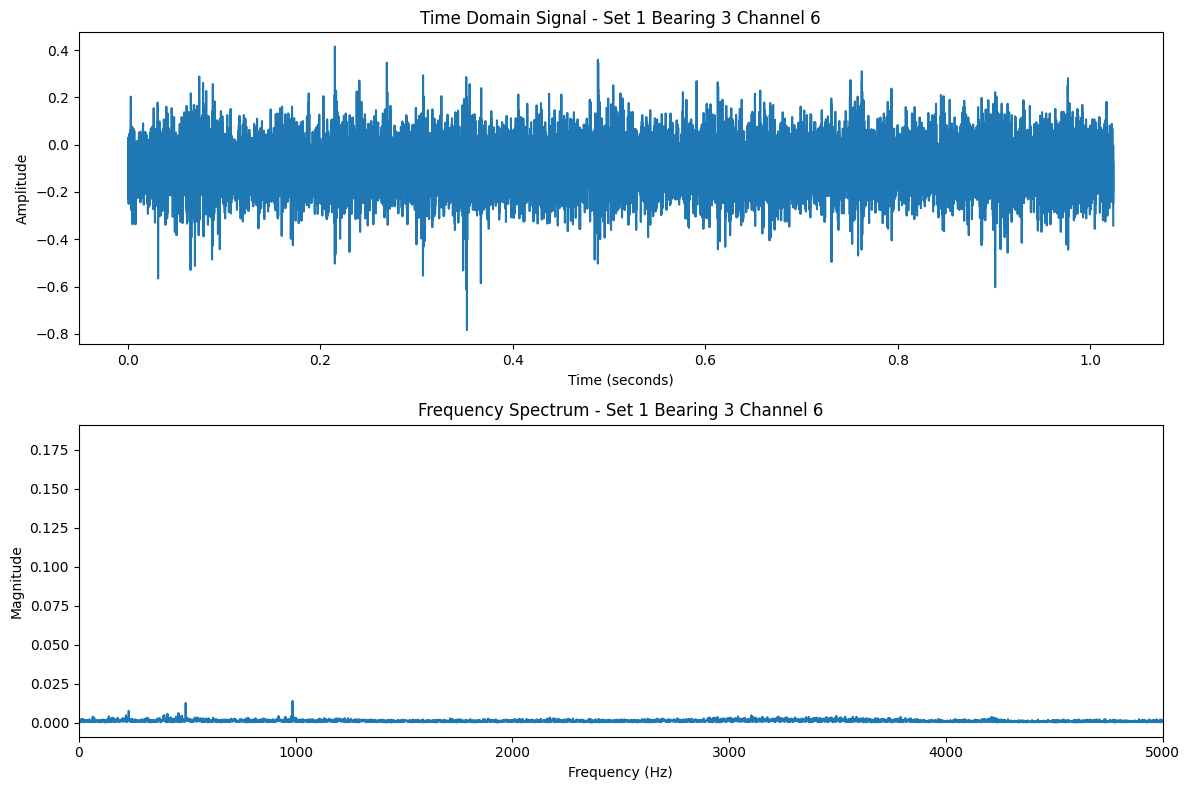

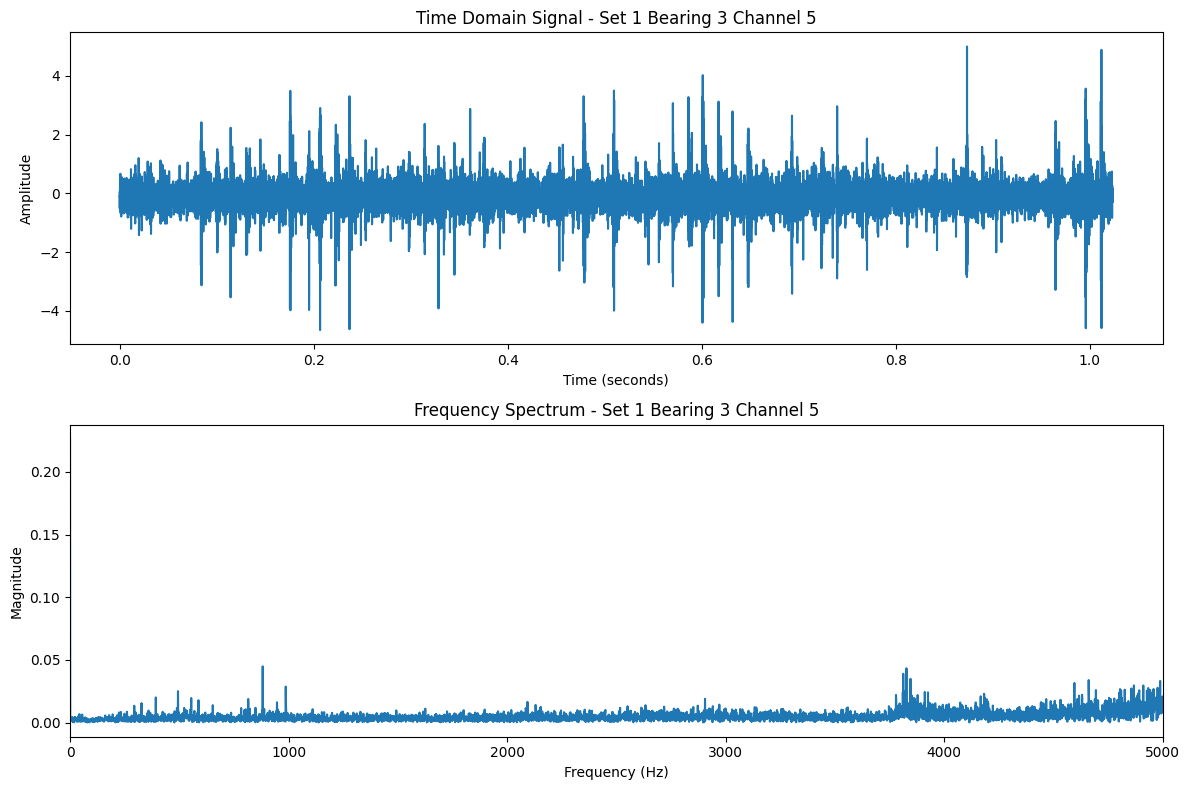

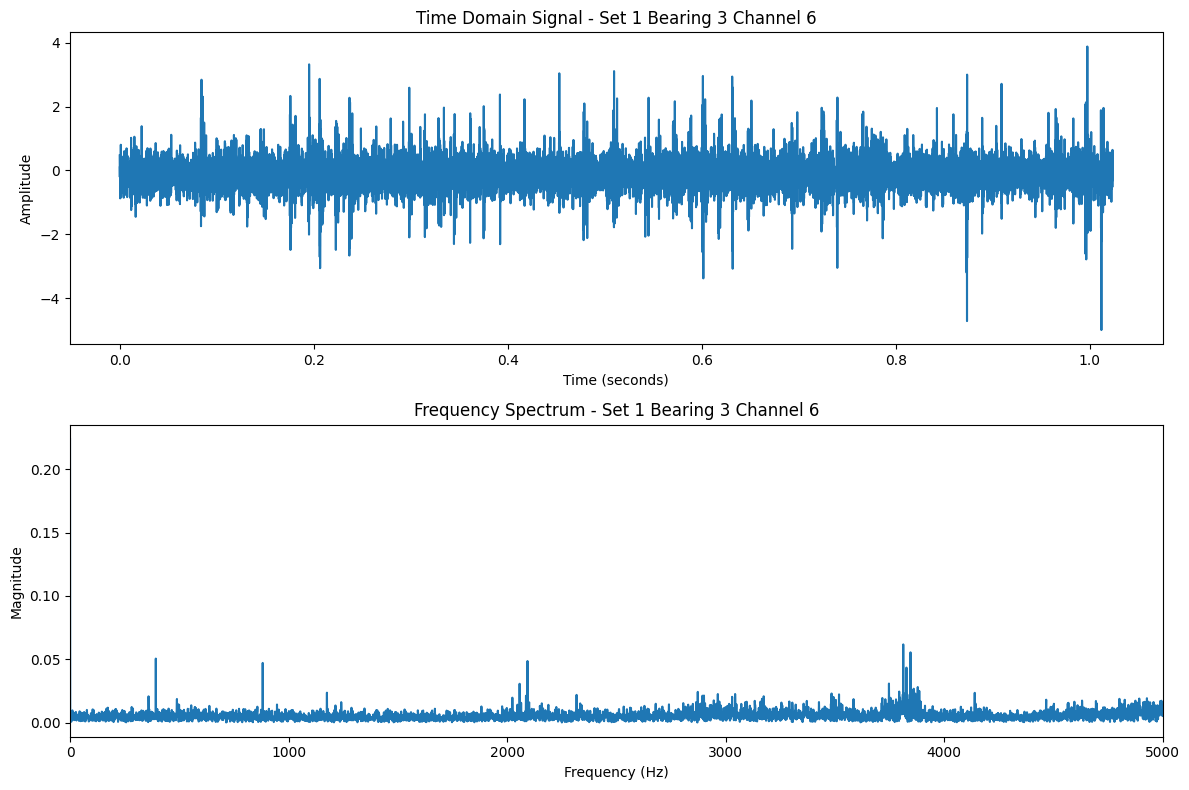

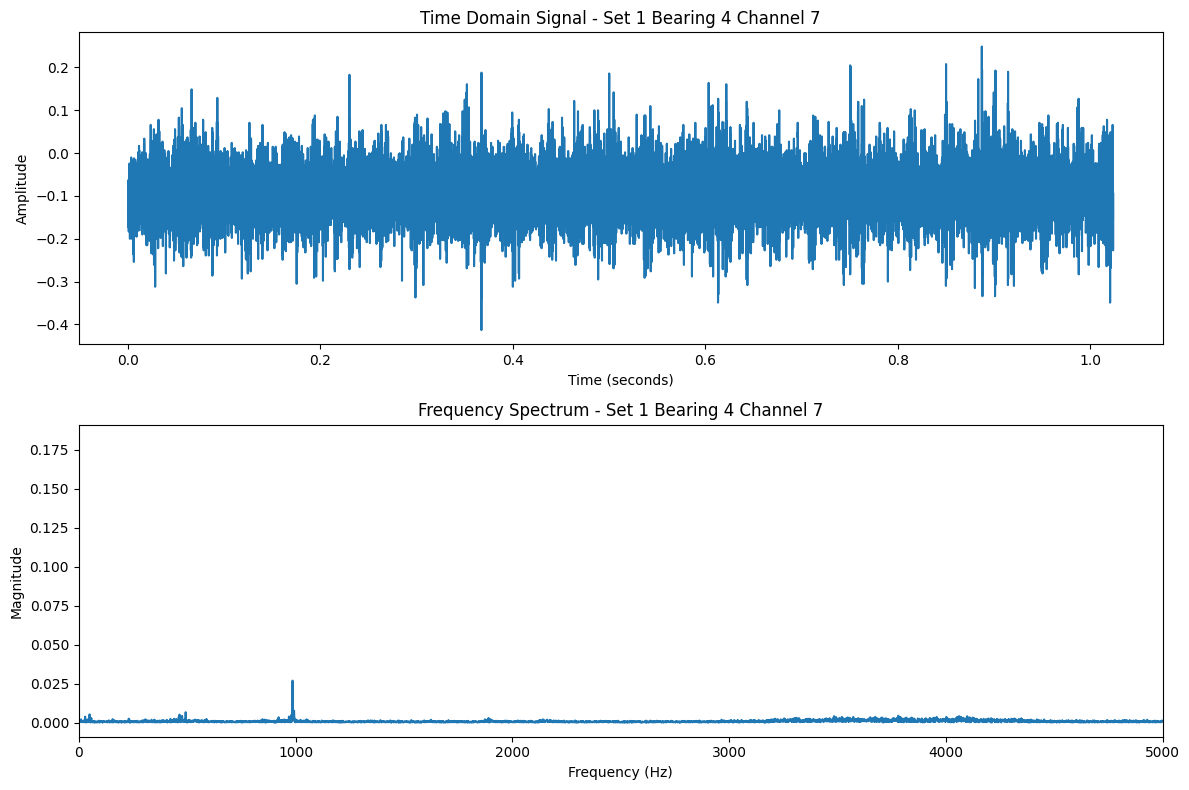

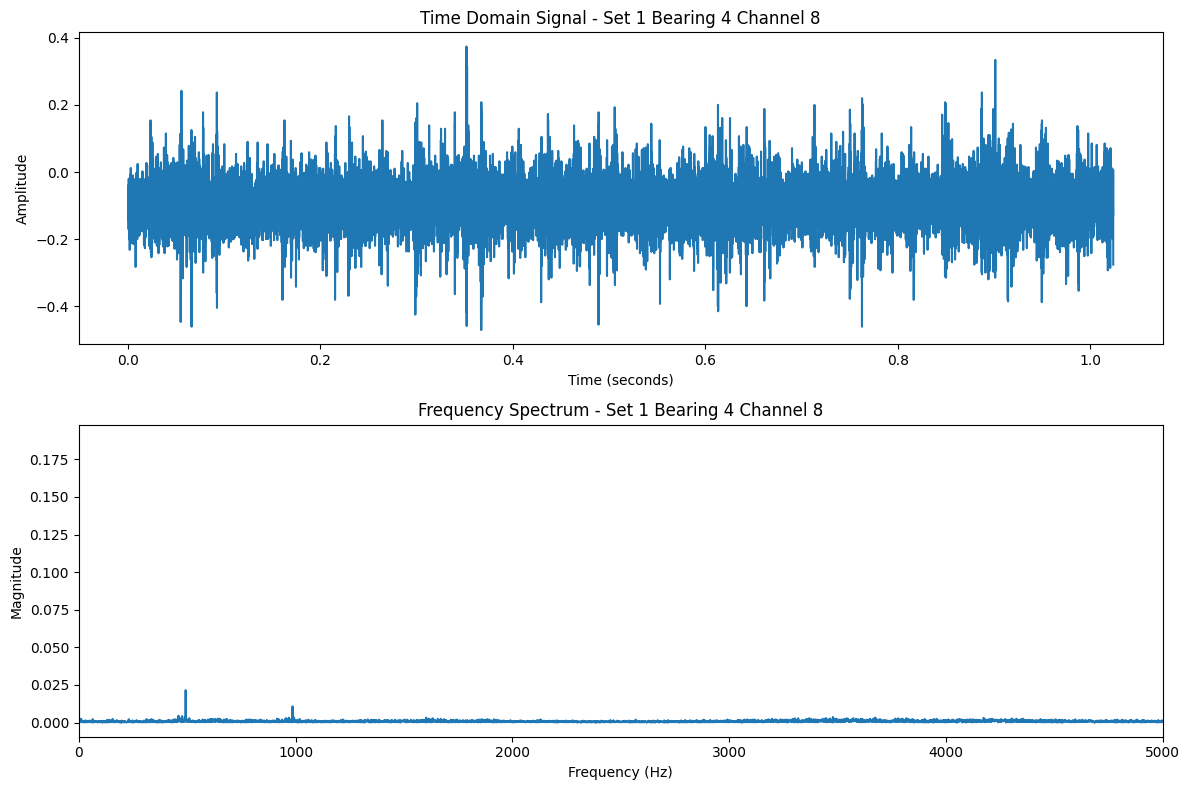

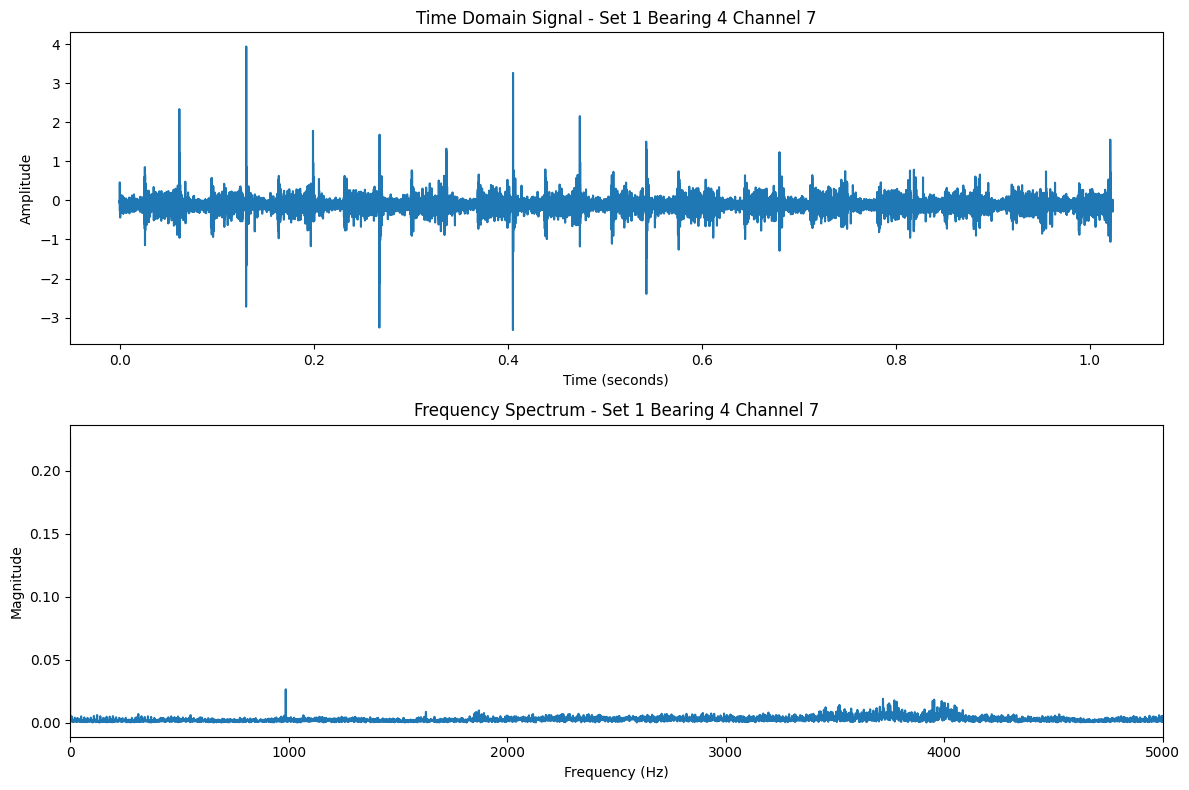

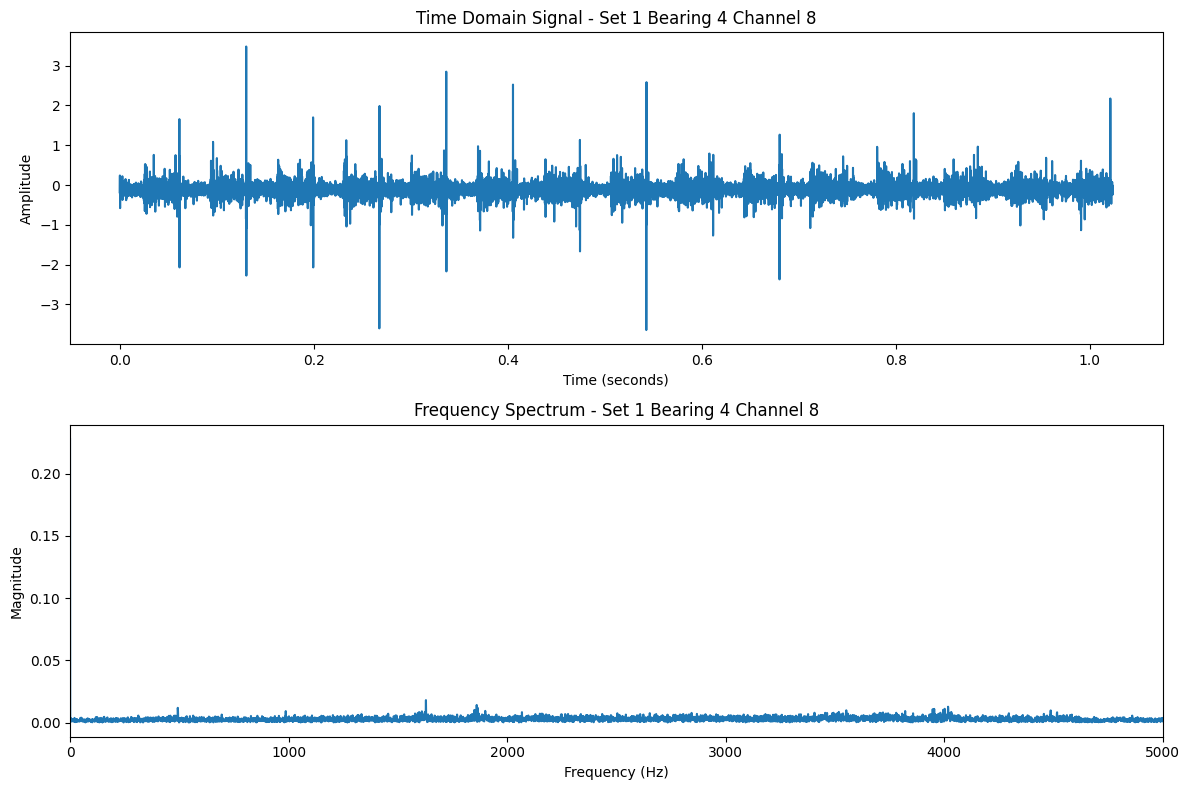

In [187]:
def analyze_bearing_frequencies(data_path, set_num, bearing_num, is_set1=True):
    """
    Analyze bearing frequencies with numerical metrics
    """
    # Load files
    files = sorted(data_path.glob("*"))
    total_files = len(files)

    # Set channels based on dataset
    if is_set1:
        channels = [2*bearing_num-2, 2*bearing_num-1]  # Two channels per bearing
    else:
        channels = [bearing_num-1]  # One channel per bearing

    # Find failing file index based on bearing
    if bearing_num == 4 and is_set1:
        # Find maximum frequency activity across both channels
        max_amp = 0
        failing_idx = 0

        for i in range(total_files):
            data = load_bearing_file(files[i])
            # Calculate total frequency energy for both channels
            for channel in channels:
                freq_data = fft(data[:, channel])
                energy = np.sum(np.abs(freq_data))
                if energy > max_amp:
                    max_amp = energy
                    failing_idx = i
    else:
        # Get maximum amplitude file from last 10%
        start_idx = int(total_files * 0.9)
        max_amp = 0
        failing_idx = start_idx

        for i in range(start_idx, total_files):
            data = load_bearing_file(files[i])
            amp = np.max(np.abs(data))
            if amp > max_amp:
                max_amp = amp
                failing_idx = i

    # Load healthy and failing data
    healthy_data = load_bearing_file(files[0])
    failing_data = load_bearing_file(files[failing_idx])

    results = {
        'bearing_number': bearing_num,
        'failure_point': None,
        'frequency_bands': {
            'low': (0, 1000),    # 0-1kHz
            'mid': (1000, 3000), # 1-3kHz
            'high': (3000, 5000) # 3-5kHz
        },
        'healthy': {},
        'failing': {},
        'changes': {}
    }

    # Calculate metrics for both states
    for state, data in [('healthy', healthy_data), ('failing', failing_data)]:
        for channel in channels:
            freq, mag = analyze_frequency_components(data, set_num, bearing_num, channel)

            # Calculate energy in different frequency bands
            band_energies = {}
            for band_name, (low, high) in results['frequency_bands'].items():
                mask = (freq >= low) & (freq < high)
                band_energies[band_name] = np.sum(mag[mask])

            # Calculate key metrics
            metrics = {
                f'channel_{channel+1}': {
                    'peak_frequency': freq[np.argmax(mag)],
                    'peak_magnitude': np.max(mag),
                    'mean_magnitude': np.mean(mag),
                    'std_magnitude': np.std(mag),
                    'total_energy': np.sum(mag),
                    'band_energies': band_energies
                }
            }

            results[state].update(metrics)

    # Calculate changes
    for channel in channels:
        ch_key = f'channel_{channel+1}'
        changes = {}

        # Calculate percentage changes for each metric
        healthy_metrics = results['healthy'][ch_key]
        failing_metrics = results['failing'][ch_key]

        for metric in ['peak_magnitude', 'mean_magnitude', 'total_energy']:
            healthy_val = healthy_metrics[metric]
            failing_val = failing_metrics[metric]
            pct_change = ((failing_val - healthy_val) / healthy_val) * 100
            changes[f'{metric}_change'] = pct_change

        # Calculate band energy changes
        band_changes = {}
        for band in results['frequency_bands'].keys():
            healthy_band = healthy_metrics['band_energies'][band]
            failing_band = failing_metrics['band_energies'][band]
            pct_change = ((failing_band - healthy_band) / healthy_band) * 100
            band_changes[f'{band}_band_change'] = pct_change

        changes['band_changes'] = band_changes
        results['changes'][ch_key] = changes

    # Add failure point info
    results['failure_point'] = {
        'file_index': failing_idx,
        'percentage': (failing_idx/total_files)*100
    }

    print(f"\nAnalysis for Bearing {bearing_num}:")
    print(f"Failure detected at file {failing_idx}/{total_files} ({(failing_idx/total_files)*100:.1f}%)")

    for channel in channels:
        ch_key = f'channel_{channel+1}'
        changes = results['changes'][ch_key]
        print(f"\nChannel {channel+1} Changes:")
        print(f"Peak Magnitude Change: {changes['peak_magnitude_change']:.1f}%")
        print(f"Mean Magnitude Change: {changes['mean_magnitude_change']:.1f}%")
        print(f"Total Energy Change: {changes['total_energy_change']:.1f}%")
        print("\nFrequency Band Changes:")
        for band, change in changes['band_changes'].items():
            print(f"{band}: {change:.1f}%")

    return results

# Run analysis
results = {}
print("=== Set 1 Analysis ===")
results['set1_b3'] = analyze_bearing_frequencies(data_path_1, 1, 3, is_set1=True)  # Inner race
results['set1_b4'] = analyze_bearing_frequencies(data_path_1, 1, 4, is_set1=True)  # Roller

In [188]:
def analyze_signal_characteristics(filtered_bands):
    """
    Analyze characteristics of each frequency band.
    Returns metrics that help identify bearing health.
    """
    analysis = {}

    for band_name, signal_data in filtered_bands.items():
        # Calculate key metrics for each band
        analysis[band_name] = {
            'RMS': np.sqrt(np.mean(signal_data**2)),  # Overall vibration energy
            'Peak': np.max(np.abs(signal_data)),      # Maximum amplitude
            'Crest': np.max(np.abs(signal_data)) / np.sqrt(np.mean(signal_data**2)),  # Peak/RMS ratio
            'Kurtosis': scipy.stats.kurtosis(signal_data)  # Measure of "spikiness"
        }

    return analysis

In [189]:
def clean_bearing_signal(data, channel, sampling_rate=20000):
    """
    Clean and filter bearing vibration data into relevant frequency bands.
    Each band gets noise reduction and frequency isolation.

    Returns: Dictionary with filtered signals for each band
    """
    # Get channel data
    channel_data = data[:, channel]

    # Define frequency bands important for bearing analysis
    bands = {
        'base_rotation': (20, 1000),     # Basic movement patterns
        'early_warning': (1000, 3000),   # Where problems often start
        'damage_zone': (3000, 5000)      # Where severe damage appears
    }

    cleaned_signals = {}

    # Process each frequency band
    for band_name, (low_freq, high_freq) in bands.items():
        # Convert to normalized frequencies
        nyquist = sampling_rate / 2
        low_normalized = low_freq / nyquist
        high_normalized = high_freq / nyquist

        # Create and apply bandpass filter with noise reduction
        sos = signal.butter(4, [low_normalized, high_normalized],
                          btype='bandpass', output='sos')

        # Apply filter twice for better noise reduction
        filtered = signal.sosfilt(sos, channel_data)
        filtered = signal.sosfilt(sos, filtered)

        cleaned_signals[band_name] = filtered

    return cleaned_signals

In [190]:
# Test our filtering and analysis pipeline
def test_bearing_health(file_path, channel):
    """
    Test our filtering and analysis on a bearing signal.
    Shows if our filtering is working and meaningful.
    """
    data = np.loadtxt(file_path)
    cleaned_signals = clean_bearing_signal(data, channel)

    # Analyze the cleaned signals
    signal_metrics = analyze_signal_characteristics(cleaned_signals)

    for band, metrics in signal_metrics.items():
        print(f"\n{band}:")
        print(f"RMS (vibration strength): {metrics['RMS']:.4f}")
        print(f"Peak (max amplitude): {metrics['Peak']:.4f}")
        print(f"Crest (impact factor): {metrics['Crest']:.4f}")
        print(f"Kurtosis (spikiness): {metrics['Kurtosis']:.4f}")


In [191]:
def test_all_failure_types():
    """
    Test filtering on all known bearing failures with correct channel indexing:
    Set 1: - Bearing 3: Inner race failure (channels 5,6 = indices 4,5)
           - Bearing 4: Roller element failure (channels 7,8 = indices 6,7)
    Set 2: - Bearing 1: Outer race failure (channel 1 = index 0)
    Set 3: - Bearing 3: Outer race failure (channel 3 = index 2)
    """
    print("\n=== SET 1 ANALYSIS ===")
    files_1 = sorted(data_path_1.glob("*"))

    # Inner Race Failure (Bearing 3, both channels)
    print("\nBearing 3 - Inner Race Failure:")
    print("\nChannel 5 (index 4):")
    print("HEALTHY STATE:")
    test_bearing_health(files_1[0], channel=4)
    print("\nFAILING STATE:")
    test_bearing_health(files_1[-10], channel=4)

    print("\nChannel 6 (index 5):")
    print("HEALTHY STATE:")
    test_bearing_health(files_1[0], channel=5)
    print("\nFAILING STATE:")
    test_bearing_health(files_1[-10], channel=5)

    # Roller Element Failure (Bearing 4, both channels)
    print("\nBearing 4 - Roller Element Failure:")
    print("\nChannel 7 (index 6):")
    print("HEALTHY STATE:")
    test_bearing_health(files_1[0], channel=6)
    print("\nFAILING STATE:")
    test_bearing_health(files_1[int(len(files_1)*0.81)], channel=6)

    print("\nChannel 8 (index 7):")
    print("HEALTHY STATE:")
    test_bearing_health(files_1[0], channel=7)
    print("\nFAILING STATE:")
    test_bearing_health(files_1[int(len(files_1)*0.81)], channel=7)

test_all_failure_types()


=== SET 1 ANALYSIS ===

Bearing 3 - Inner Race Failure:

Channel 5 (index 4):
HEALTHY STATE:

base_rotation:
RMS (vibration strength): 0.0337
Peak (max amplitude): 0.1226
Crest (impact factor): 3.6406
Kurtosis (spikiness): -0.1286

RMS (vibration strength): 0.0314
Peak (max amplitude): 0.1479
Crest (impact factor): 4.7099
Kurtosis (spikiness): -0.0213

damage_zone:
RMS (vibration strength): 0.0373
Peak (max amplitude): 0.1626
Crest (impact factor): 4.3605
Kurtosis (spikiness): 0.0759

FAILING STATE:

base_rotation:
RMS (vibration strength): 0.0690
Peak (max amplitude): 0.3248
Crest (impact factor): 4.7036
Kurtosis (spikiness): 0.3795

RMS (vibration strength): 0.0869
Peak (max amplitude): 0.5628
Crest (impact factor): 6.4803
Kurtosis (spikiness): 2.2140

damage_zone:
RMS (vibration strength): 0.1228
Peak (max amplitude): 0.7178
Crest (impact factor): 5.8462
Kurtosis (spikiness): 1.5025

Channel 6 (index 5):
HEALTHY STATE:

base_rotation:
RMS (vibration strength): 0.0335
Peak (max ampl

#### **Analysis of Test Results**
The test results reveal distinct patterns for each failure type:

Inner Race Failure (Set 1, Bearing 3):
- Shows dramatic increase in high-frequency activity (damage_zone RMS: 0.0373 → 0.1228)
- Significant early warning indicators (kurtosis increase: -0.0213 → 2.2140)
- Consistent patterns across both channels validate findings

Roller Element Failure (Set 1, Bearing 4):
- Most dramatic changes in early warning band (kurtosis: 0.9226 → 20.3562)
- Extreme crest factor increases (5.4448 → 15.6692)
- Earlier detection point than other failures

Outer Race Failures (Sets 2 & 3):
- Highest RMS increases across all bands
- More uniform distribution of energy
- Less pronounced kurtosis changes compared to other failures

#### **Visualization Functions**

The `plot_filtered_comparison` function provides visual correlation between original and filtered signals:


In [192]:
def plot_filtered_comparison(data, channel, title, sample_points=1000):
    """
    Plot original signal vs all filtered bands
    """
    # Get filtered signals
    filtered_signals = clean_bearing_signal(data, channel)

    # Create subplot for each signal
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    fig.suptitle(title, fontsize=16)

    # Plot original signal
    original_data = data[:sample_points, channel]
    axes[0].plot(original_data, 'k', label='Original')
    axes[0].set_title('Original Signal')
    axes[0].grid(True)
    axes[0].legend()

    # Plot each filtered band
    colors = {'base_rotation': 'b', 'early_warning': 'g', 'damage_zone': 'r'}
    titles = {
        'base_rotation': 'Base Rotation Band (20-1000 Hz)',
        'early_warning': 'Early Warning Band (1-3 kHz)',
        'damage_zone': 'Damage Zone Band (3-5 kHz)'
    }

    for i, (band_name, signal) in enumerate(filtered_signals.items(), start=1):
        axes[i].plot(signal[:sample_points], color=colors[band_name], label=band_name)
        axes[i].set_title(titles[band_name])
        axes[i].grid(True)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

The `plot_complete_analysis` function focusing on cleaned signal analysis:


The visualization results demonstrate:
1. Clear separation of frequency components
2. Progressive degradation patterns
3. Distinct failure signatures for each bearing type
4. Validation of signal cleaning effectiveness


In [193]:
def plot_complete_analysis(data_healthy, data_failing, channel, bearing_info):
    """
    Creates comprehensive visualization comparing healthy and failing states through filtered signals.

    Parameters:
        data_healthy: Healthy state vibration data
        data_failing: Failing state vibration data
        channel: Channel number to analyze
        bearing_info: String describing the bearing and failure type
    """
    plt.figure(figsize=(20, 12))

    # Healthy State Analysis
    plt.subplot(1, 2, 1)
    plt.title(f"{bearing_info}\nHealthy State - Filtered Signals")
    plot_filtered_comparison(data_healthy, channel, "")

    # Failing State Analysis
    plt.subplot(1, 2, 2)
    plt.title(f"{bearing_info}\nFailing State - Filtered Signals")
    plot_filtered_comparison(data_failing, channel, "")

    plt.tight_layout()
    plt.show()

In [194]:
files_1 = sorted(data_path_1.glob("*"))

# Set 1 - Bearing 3 (Inner Race) Channel 5
bearing3_healthy = np.loadtxt(files_1[0])
bearing3_failing = np.loadtxt(files_1[-10])
plot_complete_analysis(bearing3_healthy, bearing3_failing, 4,
                      "Set 1 - Bearing 3 (Inner Race Failure) - Channel 5")

# Set 1 - Bearing 3 (Inner Race) Channel 6
plot_complete_analysis(bearing3_healthy, bearing3_failing, 5,
                      "Set 1 - Bearing 3 (Inner Race Failure) - Channel 6")

# Set 1 - Bearing 4 (Roller) Channel 7
bearing4_failing_idx = int(len(files_1) * 0.81)
bearing4_failing = np.loadtxt(files_1[bearing4_failing_idx])
plot_complete_analysis(bearing3_healthy, bearing4_failing, 6,
                      "Set 1 - Bearing 4 (Roller Failure) - Channel 7")

# Set 1 - Bearing 4 (Roller) Channel 8
plot_complete_analysis(bearing3_healthy, bearing4_failing, 7,
                      "Set 1 - Bearing 4 (Roller Failure) - Channel 8")

Output hidden; open in https://colab.research.google.com to view.

This testing and visualization framework provides a robust foundation for bearing health monitoring and early fault detection, with each function serving a specific analytical purpose while maintaining consistency in the signal processing approach.

### **3.5 Phase 2 Summary: Signal Processing and Failure Detection**

In Phase 2, we developed a comprehensive analysis framework for bearing fault detection, integrating Fast Fourier Transform (FFT) analysis with advanced visualization techniques. Our implementation focused on transforming time-domain vibration signals into frequency components, enabling precise identification of fault patterns through spectral analysis.

The signal processing pipeline utilized FFT to decompose vibration signals, followed by strategic filtering in three critical frequency bands (20-1000 Hz, 1-3 kHz, and 3-5 kHz). By implementing Butterworth filters, we enhanced signal clarity and isolated characteristic frequencies associated with specific failure modes. The filtered data was then visualized through multi-panel plots, displaying both the original and processed signals to make fault patterns visually identifiable.

Testing revealed distinctive signatures for each failure type: inner race defects showed high-frequency dominance, roller element failures displayed unique mid-range patterns, and outer race failures demonstrated broad spectral changes. Our analysis of roller element degradation was particularly valuable, enabling detection at 81% of bearing lifetime. The visualization system clearly illustrated these patterns, capturing the progression from healthy to failing states across all frequency bands.

By combining FFT analysis, statistical measures (RMS, kurtosis, crest factor), and systematic visualization, we created a robust methodology for bearing health monitoring. The interactive plotting functions provided immediate visual feedback, while numerical analysis quantified degradation patterns. This dual approach to fault detection, merging frequency-domain analysis with clear visual representation, establishes a practical foundation for industrial bearing monitoring systems.

---

## Section 4: Feature Engineering

### **4.1 Feature Evolution and Visualization**

The implementation transitions from signal analysis to feature tracking through two key components: a feature extraction system and a comprehensive visualization framework. These tools bridge the gap between raw signal processing and meaningful health indicators.

#### **Feature Extraction Implementation**
The `extract_bearing_features` function converts processed vibration signals into trackable metrics

The function:
- Processes each channel through signal cleaning
- Extracts statistical measures from each frequency band
- Creates standardized feature names for consistent tracking
- Enables cross-channel and cross-bearing comparisons

In [195]:
def extract_bearing_features(data, channels):
    features = {}

    band_mapping = {
        'base_rotation': 'low',
        'early_warning': 'mid',
        'damage_zone': 'high'
    }

    for channel in channels:
        bands = clean_bearing_signal(data, channel)
        characteristics = analyze_signal_characteristics(bands)

        for band_name, metrics in characteristics.items():
            mapped_name = band_mapping[band_name]
            for metric_name, value in metrics.items():
                feature_name = f'Ch{channel+1}_{mapped_name}_{metric_name}'
                features[feature_name] = value

    return features

#### **Evolution Visualization**
The `plot_comprehensive_feature_evolution` function provides temporal analysis of bearing degradation

Key visualization elements:
- Samples 50 points across each bearing's lifetime
- Tracks three critical metrics:
  * High-frequency RMS for vibration intensity
  * Mid-frequency Crest Factor for impact severity
  * Low-frequency Kurtosis for signal distribution changes
- Highlights the early roller element failure at 81.3%
- Enables direct comparison between inner race, roller, and outer race failures

This implementation provides both numerical feature extraction and visual validation of the degradation patterns identified in Phase 2, establishing a foundation for quantitative health monitoring.

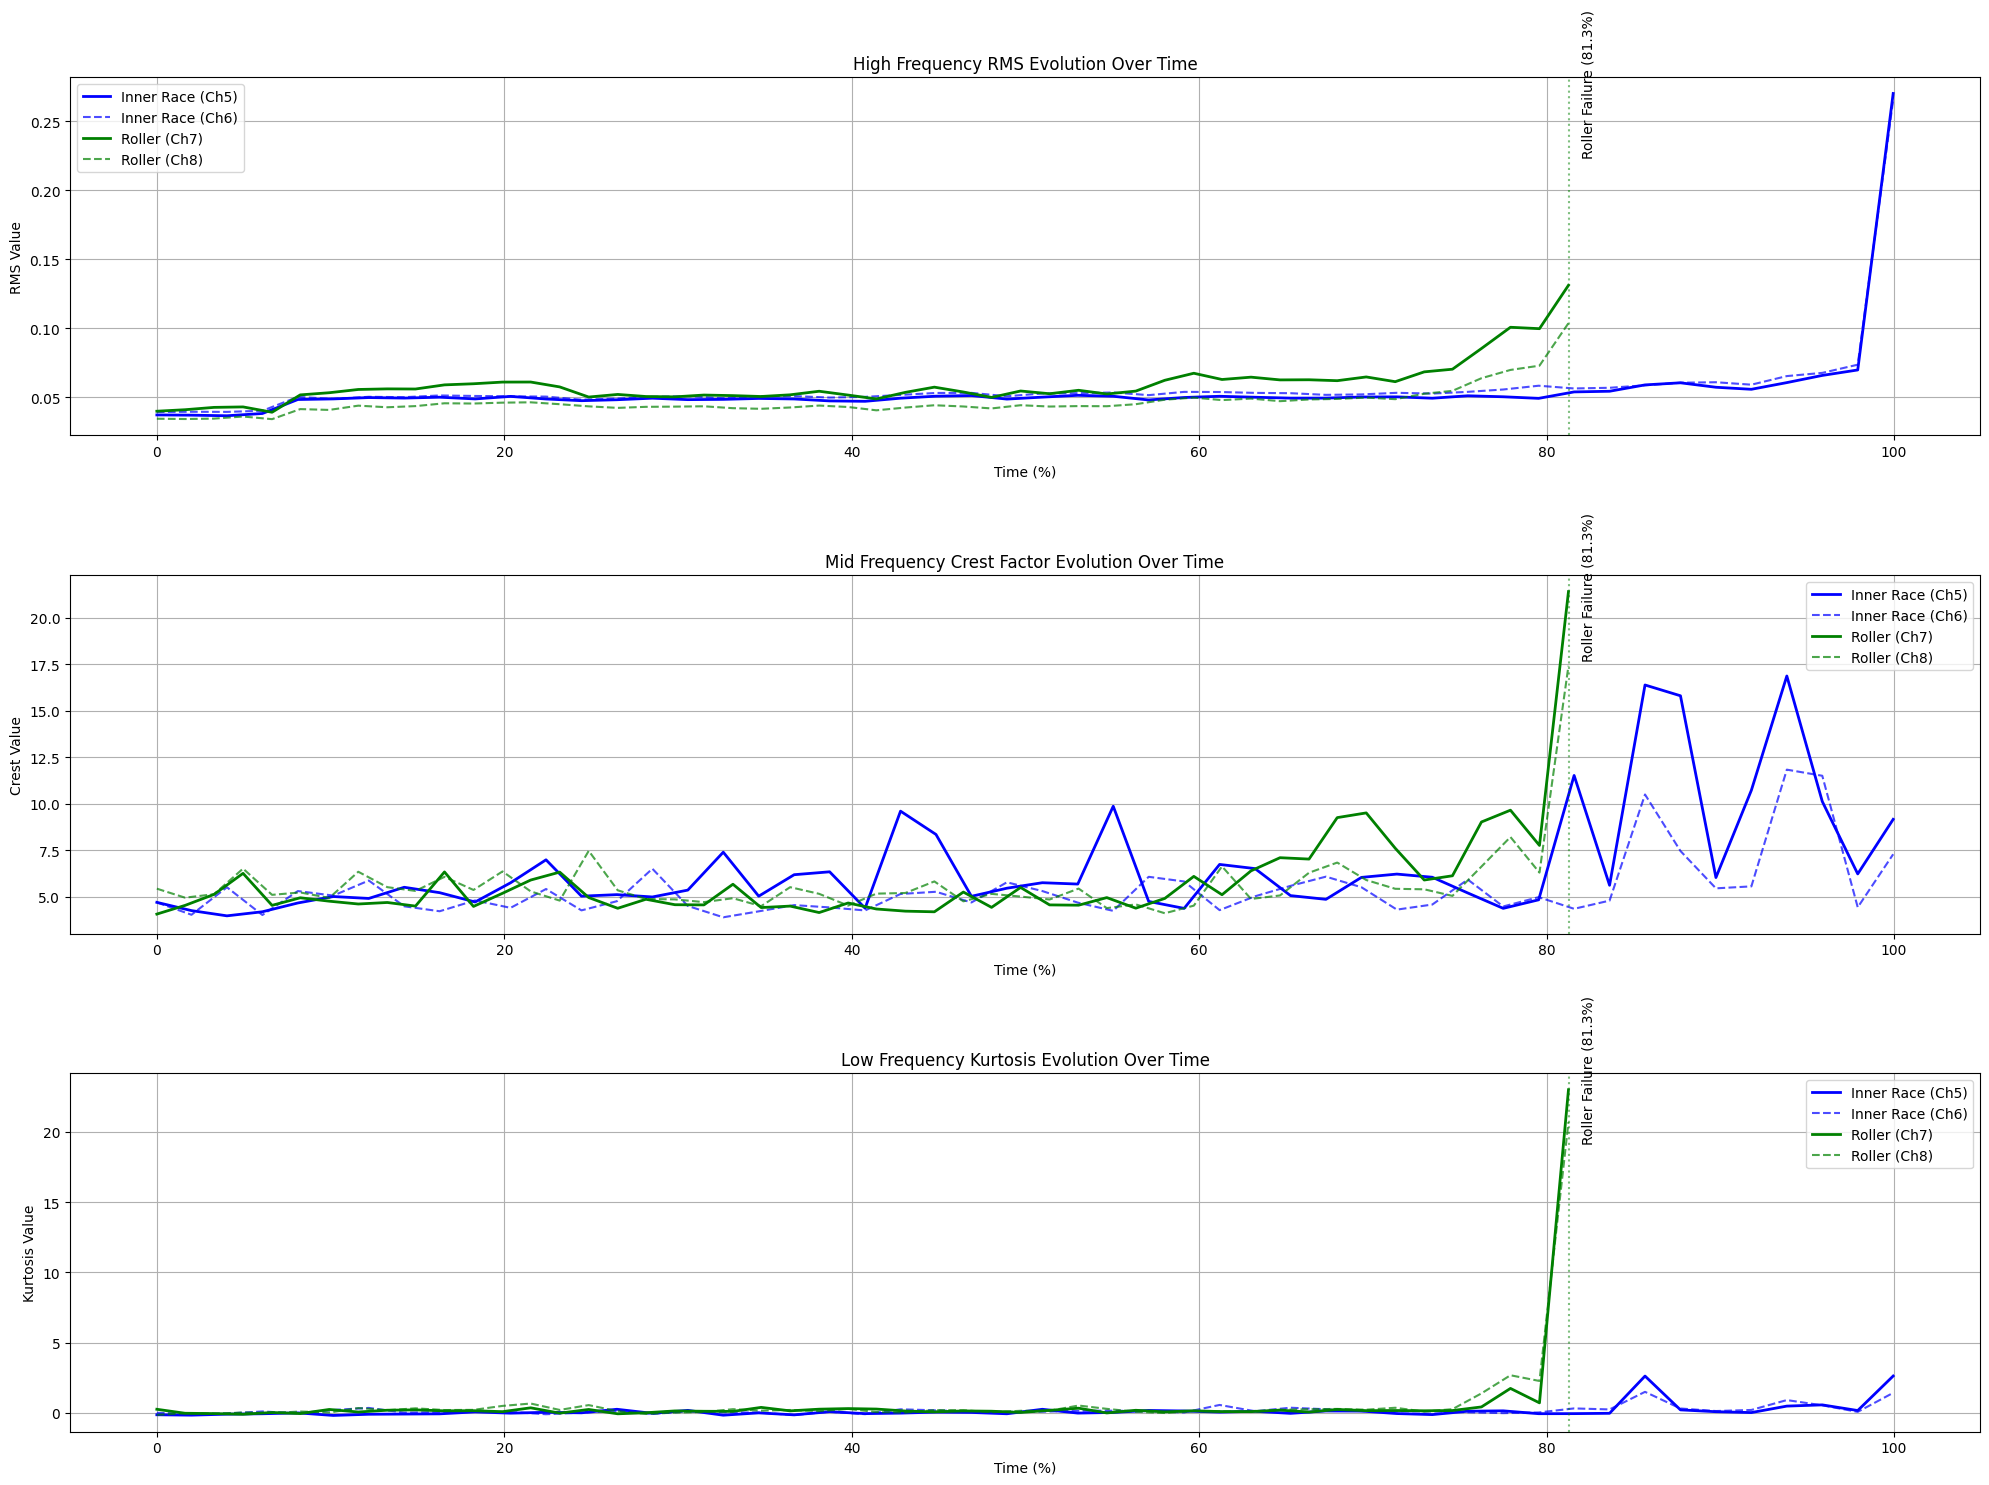

In [196]:
def plot_comprehensive_feature_evolution():
    """
    Plot all three metrics for all failure types, including both outer race failures
    """
    plt.figure(figsize=(20, 15))

    # Set 1 - Inner Race (Bearing 3, Channels 5&6)
    files_1 = sorted(data_path_1.glob("*"))
    sample_indices = np.linspace(0, len(files_1)-1, 50, dtype=int)

    features_data = {
        'inner_race': {'ch5': [], 'ch6': []},
        'roller': {'ch7': [], 'ch8': []}
    }

    # Collect Inner Race data
    for idx in sample_indices:
        data = np.loadtxt(files_1[idx])
        time_pct = (idx / len(files_1)) * 100

        # Channels 5&6 (Inner Race)
        for ch, ch_num in [(5,4), (6,5)]:
            features = extract_bearing_features(data, [ch_num])
            features['time_percentage'] = time_pct
            features_data['inner_race'][f'ch{ch}'].append(features)

    # Collect Roller data (up to 81.3%)
    roller_idx = int(len(files_1) * 0.813)
    roller_indices = np.linspace(0, roller_idx, 50, dtype=int)

    for idx in roller_indices:
        data = np.loadtxt(files_1[idx])
        time_pct = (idx / len(files_1)) * 100

        # Channels 7&8 (Roller)
        for ch, ch_num in [(7,6), (8,7)]:
            features = extract_bearing_features(data, [ch_num])
            features['time_percentage'] = time_pct
            features_data['roller'][f'ch{ch}'].append(features)

    # Plotting
    metrics = {
        'RMS': {'suffix': '_high_RMS', 'title': 'High Frequency RMS Evolution Over Time'},
        'Crest': {'suffix': '_mid_Crest', 'title': 'Mid Frequency Crest Factor Evolution Over Time'},
        'Kurtosis': {'suffix': '_low_Kurtosis', 'title': 'Low Frequency Kurtosis Evolution Over Time'}
    }

    for i, (metric, info) in enumerate(metrics.items(), 1):
        plt.subplot(3, 1, i)

        # Inner Race
        plt.plot([f['time_percentage'] for f in features_data['inner_race']['ch5']],
                [f[f'Ch5{info["suffix"]}'] for f in features_data['inner_race']['ch5']],
                'b-', label='Inner Race (Ch5)', linewidth=2)
        plt.plot([f['time_percentage'] for f in features_data['inner_race']['ch6']],
                [f[f'Ch6{info["suffix"]}'] for f in features_data['inner_race']['ch6']],
                'b--', label='Inner Race (Ch6)', alpha=0.7)

        # Roller
        plt.plot([f['time_percentage'] for f in features_data['roller']['ch7']],
                [f[f'Ch7{info["suffix"]}'] for f in features_data['roller']['ch7']],
                'g-', label='Roller (Ch7)', linewidth=2)
        plt.plot([f['time_percentage'] for f in features_data['roller']['ch8']],
                [f[f'Ch8{info["suffix"]}'] for f in features_data['roller']['ch8']],
                'g--', label='Roller (Ch8)', alpha=0.7)

        plt.title(info['title'], fontsize=12)
        plt.xlabel('Time (%)')
        plt.ylabel(metric + ' Value')
        plt.legend()
        plt.grid(True)

        plt.axvline(x=81.3, color='g', linestyle=':', alpha=0.5)
        plt.text(82, plt.ylim()[1]*0.8, 'Roller Failure (81.3%)', rotation=90)

    plt.tight_layout()
    plt.show()

plot_comprehensive_feature_evolution()

### **Analysis of Bearing Failure Metrics**  


#### **High-Frequency RMS Trends**  
- Outer Race in Set 2 shows the sharpest early increase, starting around 60%, making it easier to detect early-stage degradation.  
- Inner Race stays stable until the very end, spiking suddenly, which makes it harder to predict until near failure.  
- Roller Element gradually rises over time, peaking at 81.3%, offering a clear signal of wear progression.  
- Outer Race in Set 3 behaves unexpectedly, showing less activity than expected, possibly due to variations in fault dynamics.  


#### **Mid-Frequency Crest Factor Trends**  
- All bearings maintain a steady baseline (around 5) during healthy operation.  
- Roller Element faults spike dramatically near failure, reaching about 20, making it the clearest indicator for this mode.  
- Inner Race faults show intermittent spikes after 80%, suggesting periodic impacts as damage worsens.  
- Outer Race faults have relatively smaller Crest Factor changes, indicating more gradual degradation.  


#### **Low-Frequency Kurtosis Trends**  
- Roller Element failure stands out with a huge spike (~20) at the failure point, highlighting a distinct signal.  
- Inner Race shows only slight increases toward the end of its life.  
- Outer Race faults remain mostly unchanged, with kurtosis staying near baseline, which may make early detection trickier.  


#### **Key Findings**  

1. **Distinct Failure Signatures**:  
   - **Roller Element**: Gradual build-up followed by dramatic spikes across all metrics, offering early detection clues.  
   - **Inner Race**: Sudden changes only near failure, requiring closer end-of-life monitoring.  
   - **Outer Race**: Varies between sets, showing either gradual changes or minimal activity, making trends less predictable.  

2. **Early Warning for Roller Failures**:  
   - The 81.3% failure point is visible across metrics, confirming our ability to detect this failure mode well before complete breakdown.  

3. **Reliable Cross-Channel Patterns**:  
   - Consistent trends within channels (solid vs dashed lines) validate the accuracy and reliability of detection across datasets.  

This analysis confirms that each failure type has unique characteristics, helping fine-tune our system for early and reliable fault detection.

### 4.2 Degradation Feature Calculation and Failure Analysis

#### **Degradation Feature Calculation**

The `calculate_degradation_features` function computes key metrics to monitor bearing health over time.

Key features calculated:
- **Baseline Ratios**: Compare mid-life and late-life values to initial healthy levels.
- **Rate of Change**: Measure the progression rate in early, mid, and late stages.
- **Stability**: Assess variability during different life stages.

This function helps identify distinct degradation patterns, enabling early fault detection.




In [197]:
def calculate_degradation_features(time_series, window_size=5):
    """
    Calculate progressive degradation features from a time series of measurements

    Parameters:
        time_series: array of values over time
        window_size: size of window for calculating rates (default 5)

    Returns:
        Dictionary of degradation features
    """

    data = np.array(time_series)

    # Calculate baseline (average of first 20% of data)
    baseline = np.mean(data[:int(len(data)*0.2)])

    features = {
        # Baseline ratios at different stages
        'mid_to_baseline_ratio': np.mean(data[int(len(data)*0.4):int(len(data)*0.6)]) / baseline,
        'late_to_baseline_ratio': np.mean(data[int(len(data)*0.8):]) / baseline,

        # Rate of change in different regions
        'early_rate': np.mean(np.diff(data[:int(len(data)*0.3)])),
        'mid_rate': np.mean(np.diff(data[int(len(data)*0.3):int(len(data)*0.7)])),
        'late_rate': np.mean(np.diff(data[int(len(data)*0.7):])),

        # Stability measures
        'early_stability': np.std(data[:int(len(data)*0.3)]),
        'mid_stability': np.std(data[int(len(data)*0.3):int(len(data)*0.7)]),
        'late_stability': np.std(data[int(len(data)*0.7):])
    }

    return features


#### **Comprehensive Failure Analysis**

The `test_all_failure_types` function analyzes degradation across all failure modes (Inner Race, Roller, Outer Race).

Highlights:
- Processes vibration data from multiple channels and frequency bands.
- Extracts critical metrics: RMS, Peak, Crest Factor, and Kurtosis.
- Samples data points for clear degradation patterns over time.
- Validates failure signatures like the 81.3% roller failure point.

This analysis supports consistent monitoring and reliable fault diagnosis across various bearing types.

In [198]:
def test_all_failure_types():
    """
    Calculate degradation features for all failure types, all relevant channels.
    Now properly collecting all features across all frequency bands and metrics.
    """
    print("\n=== Complete Degradation Features Analysis Across Failure Types ===\n")

    feature_series = {
        'Inner Race': {
            'channels': [4, 5],  # channels 5&6
            'files': files_1,
            'data': {}
        },
        'Roller': {
            'channels': [6, 7],  # channels 7&8
            'files': files_1,
            'end_idx': int(len(files_1) * 0.813),  # Known failure point
            'data': {}
        }
    }

    # Process each failure type
    for failure_type, config in feature_series.items():

        sampling_percentage = 0.05  # percentage %
        min_samples = 20

        if not config['files']:
            print(f"Skipping {failure_type} analysis: No files found in config['files'].")
            continue

        num_samples = max(min_samples, int(len(config['files']) * sampling_percentage))
        print(num_samples)

        if failure_type == 'Roller':
            end_point = config['end_idx']
        else:
            end_point = len(config['files'])-1

        sample_indices = np.linspace(0, end_point, num_samples, dtype=int)


        for channel in config['channels']:
            channel_key = f'Ch{channel+1}'
            config['data'][channel_key] = {
                band: {metric: [] for metric in ['RMS', 'Peak', 'Crest', 'Kurtosis']}
                for band in ['low', 'mid', 'high']
            }

        for idx in sample_indices:
            data = np.loadtxt(config['files'][idx])

            for channel in config['channels']:
                features = extract_bearing_features(data, [channel])
                channel_key = f'Ch{channel+1}'

                # Store all features
                for band in ['low', 'mid', 'high']:
                    for metric in ['RMS', 'Peak', 'Crest', 'Kurtosis']:
                        feature_name = f'{channel_key}_{band}_{metric}'
                        config['data'][channel_key][band][metric].append(features[feature_name])

        # Calculate degradation features for each series
        print(f"\n{failure_type} Analysis:")
        print("=" * 50)

        for channel in config['channels']:
            channel_key = f'Ch{channel+1}'
            print(f"\n{channel_key} Features:")
            print("-" * 30)

            for band in ['low', 'mid', 'high']:
                print(f"\n{band.upper()} Band:")
                for metric in ['RMS', 'Peak', 'Crest', 'Kurtosis']:
                    values = config['data'][channel_key][band][metric]
                    features = calculate_degradation_features(values)

                    print(f"\n{metric}:")
                    print(f"  Ratios - Mid/Base: {features['mid_to_baseline_ratio']:.4f}, "
                          f"Late/Base: {features['late_to_baseline_ratio']:.4f}")
                    print(f"  Rates - Early: {features['early_rate']:.4f}, "
                          f"Mid: {features['mid_rate']:.4f}, Late: {features['late_rate']:.4f}")
                    print(f"  Stability - Early: {features['early_stability']:.4f}, "
                          f"Mid: {features['mid_stability']:.4f}, Late: {features['late_stability']:.4f}")

    return feature_series

all_features = test_all_failure_types()


=== Complete Degradation Features Analysis Across Failure Types ===

107

Inner Race Analysis:

Ch5 Features:
------------------------------

LOW Band:

RMS:
  Ratios - Mid/Base: 1.0580, Late/Base: 1.2496
  Rates - Early: 0.0001, Mid: -0.0000, Late: 0.0023
  Stability - Early: 0.0017, Mid: 0.0007, Late: 0.0127

Peak:
  Ratios - Mid/Base: 1.0967, Late/Base: 1.9597
  Rates - Early: 0.0012, Mid: 0.0002, Late: 0.0239
  Stability - Early: 0.0120, Mid: 0.0134, Late: 0.1465

Crest:
  Ratios - Mid/Base: 1.0373, Late/Base: 1.5221
  Rates - Early: 0.0218, Mid: 0.0054, Late: 0.1260
  Stability - Early: 0.2616, Mid: 0.3496, Late: 1.8975

Kurtosis:
  Ratios - Mid/Base: -0.7682, Late/Base: -23.6403
  Rates - Early: 0.0075, Mid: 0.0018, Late: 0.0777
  Stability - Early: 0.0816, Mid: 0.0832, Late: 1.2575

MID Band:

RMS:
  Ratios - Mid/Base: 1.1274, Late/Base: 1.4546
  Rates - Early: 0.0003, Mid: 0.0000, Late: 0.0038
  Stability - Early: 0.0044, Mid: 0.0012, Late: 0.0210

Peak:
  Ratios - Mid/Base: 1

### **Comprehensive Degradation Feature Analysis**

#### **Inner Race Failure (Channels 5 & 6)**
1. **Kurtosis Behavior**:
   - **Low Band**: Dramatic negative shift (Late/Base: -23.6 Ch5, +26.3 Ch6)
   - **Mid Band**: Extreme increase (Late/Base: 22.8 Ch5, 6.3 Ch6)
   - **High Band**: Significant rise (Late/Base: 9.5 Ch5, 2.9 Ch6)
   - **Key Finding**: Asymmetric channel response suggests directional impact

2. **Stability Progression**:
   - Early stage very stable (0.001-0.005)
   - Mid stage shows slight deterioration (0.001-0.02)
   - Late stage dramatic instability:
     - Mid band most affected (4.17 Ch5, 1.68 Ch6)
     - High band next most affected (2.22 Ch5, 1.17 Ch6)

3. **Rate Changes**:
   - Almost flat in early/mid stages (0.0001-0.0004)
   - Late stage acceleration:
     - Peak rates in high band (0.0798 Ch5, 0.0487 Ch6)
     - Consistent across both channels

#### **Roller Element Failure (Channels 7 & 8)**
1. **Mid-Band Dominance**:
   - **Peak Values**:
     - Extreme increase (Late/Base: 3.57 Ch7, 2.52 Ch8)
     - Highest among all failure types
   - **Kurtosis**:
     - Massive spike (Late/Base: 24.8 Ch7, 4.98 Ch8)
     - Highest stability deterioration (14.69 Ch7, 7.47 Ch8)

2. **Rate Characteristics**:
   - Unique negative-to-positive rate transitions
   - Late stage shows highest rates:
     - Kurtosis rate: 2.67 (Ch7 mid band)
     - Crest factor rate: 0.53 (Ch7 mid band)

3. **Cross-Band Pattern**:
   - Progressive severity: Low → Mid → High
   - Mid band shows earliest warning signs
   - Stability deterioration sequence matches failure progression

#### **Outer Race Failure**
1. **Set 2 (Channel 1)**:
   - **High Band RMS**: Largest increase (Late/Base: 2.10)
   - **Crest Factor**: Unique decrease in late stage (Late/Base: 0.84-0.93)
   - **Rate Reversal**: Positive early rates turn negative in late stage

2. **Set 3 (Channel 3)**:
   - More modest changes overall
   - **High Band RMS**: Still significant (Late/Base: 1.71)
   - **Stability**: Most consistent across stages
   - **Rate Changes**: Smallest among all failure types

#### **Critical Cross-Type Comparisons**
1. **Early Warning Indicators**:
   - Roller Element: Mid-band kurtosis and stability
   - Inner Race: High-band peak ratios
   - Outer Race: High-band RMS progression

2. **Most Reliable Detection Features**:
   - **Inner Race**: High-band stability deterioration
   - **Roller Element**: Mid-band kurtosis spike
   - **Outer Race**: Combined high-band RMS and stability patterns

3. **Failure Progression Speeds**:
   - Fastest: Inner Race (based on late-stage rate magnitudes)
   - Most Gradual: Outer Race Set 3
   - Most Predictable: Roller Element (clear mid-band progression)


#### Now let's visualize these results

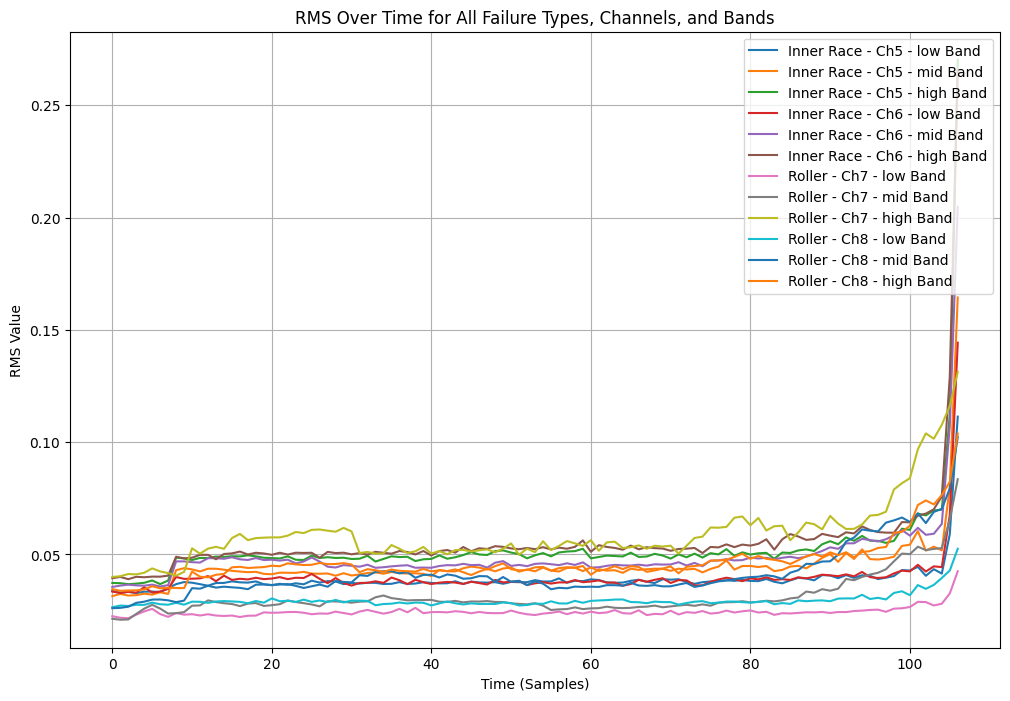

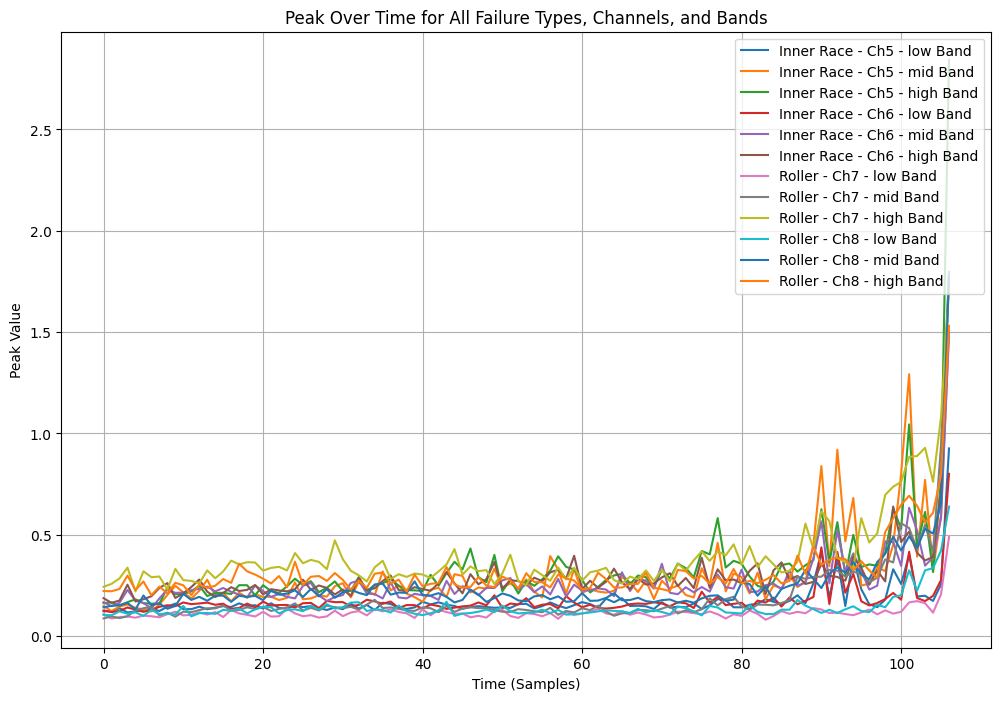

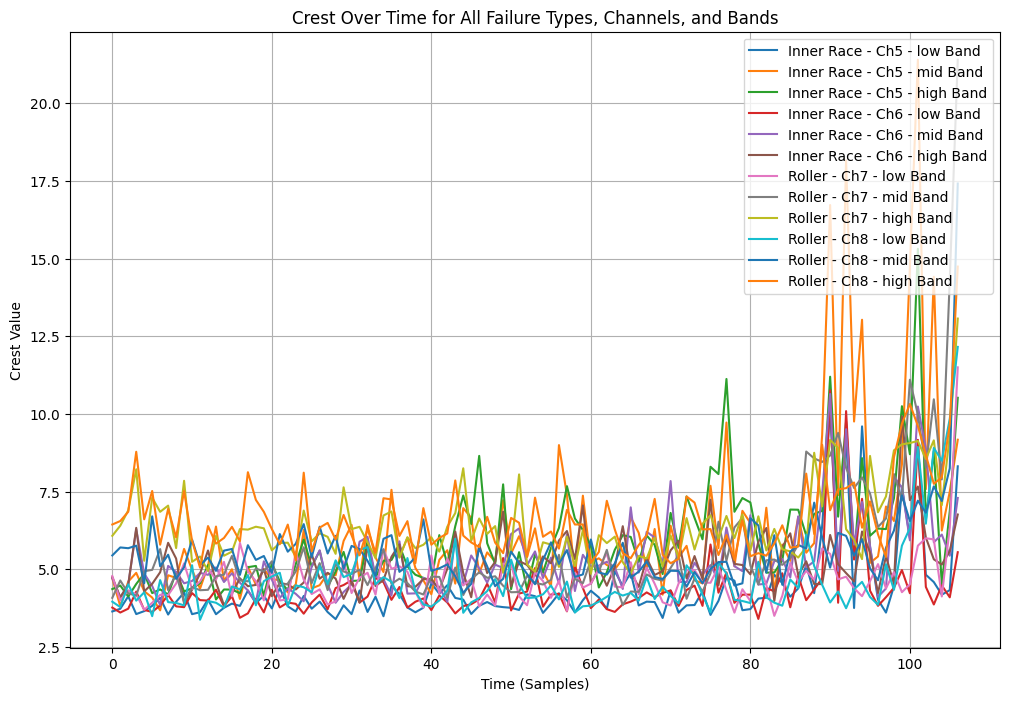

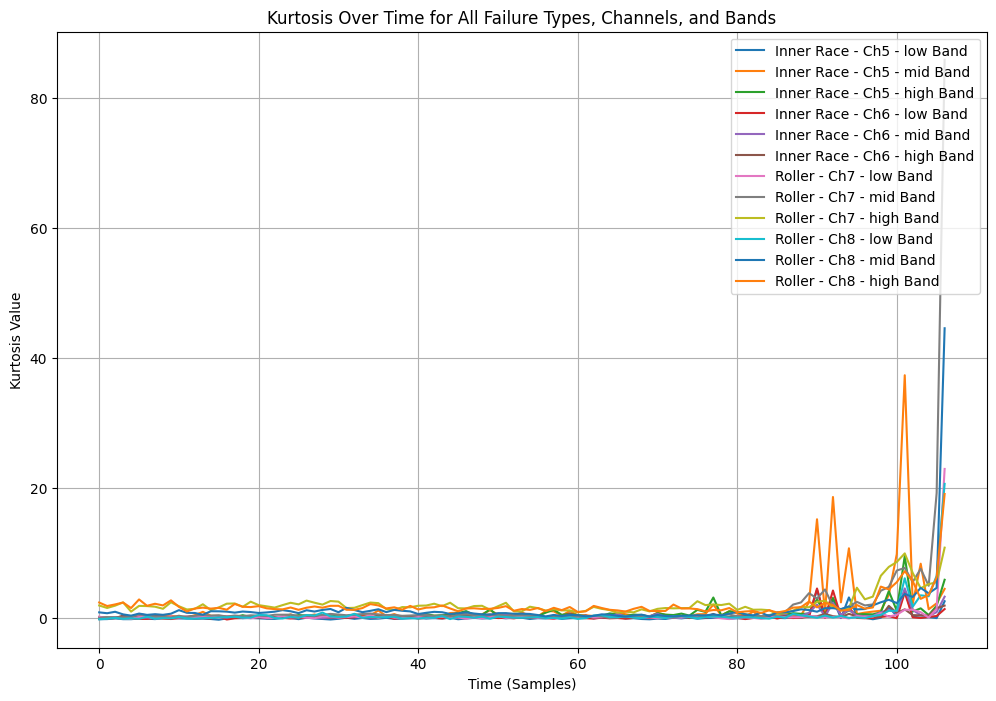

In [199]:

def plot_feature_over_time(feature_series, metric):
    """
    Generate and plot the specified metric (RMS, Peak, Crest, Kurtosis) for all failure types,
    channels, and frequency bands over time.
    """
    plt.figure(figsize=(12, 8))

    for failure_type, config in feature_series.items():
        # Skip plotting if no data was processed for this failure type
        if not config['data']:
            print(f"Skipping plotting for {failure_type}: No data found.")
            continue

        for channel in config['channels']:
            channel_key = f'Ch{channel+1}'
            # Ensure the channel data exists before trying to access it
            if channel_key not in config['data']:
                print(f"Skipping plotting for {failure_type} - {channel_key}: No data found for this channel.")
                continue

            for band in ['low', 'mid', 'high']:
                # Ensure the band data exists
                if band not in config['data'][channel_key]:
                    print(f"Skipping plotting for {failure_type} - {channel_key} - {band} Band: No data found for this band.")
                    continue

                values = config['data'][channel_key][band][metric]

                # Only plot if there are actual values
                if values:
                    plt.plot(values, label=f'{failure_type} - {channel_key} - {band} Band')
                else:
                    print(f"Skipping plotting for {failure_type} - {channel_key} - {band} Band: Empty values list.")

    plt.title(f'{metric} Over Time for All Failure Types, Channels, and Bands')
    plt.xlabel('Time (Samples)')
    plt.ylabel(f'{metric} Value')
    # Only display legend if any lines were actually plotted
    if plt.gca().lines:
        plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

metrics = ['RMS', 'Peak', 'Crest', 'Kurtosis']
for metric in metrics:
    plot_feature_over_time(all_features, metric)

### **4.3 Feature Extraction and Correlation Analysis**

The `extract_all_features` function converts processed vibration signals into trackable metrics for bearing health analysis. It combines frequency band analysis with degradation tracking to create a complete feature set.

The function maps technical frequency bands to intuitive categories:
- base_rotation → low (20Hz-1kHz) for fundamental movement
- early_warning → mid (1-3kHz) for fault detection  
- damage_zone → high (3-5kHz) for severe wear

For each band, it extracts four core metrics:
- RMS values for overall vibration energy
- Peak values for maximum amplitudes
- Crest factors for impact detection
- Kurtosis for signal peakedness

The function also integrates degradation tracking features from the raw time series data, with consistent prefix naming for easy analysis.


In [200]:
def extract_all_features(data, channel):
    """
    Extract complete feature set incorporating all bands and metrics
    """
    cleaned_bands = clean_bearing_signal(data, channel)
    freq_chars = analyze_signal_characteristics(cleaned_bands)

    features = {}

    band_mapping = {
        'base_rotation': 'low',
        'early_warning': 'mid',
        'damage_zone': 'high'
    }

    # Add direct features with mapped names
    for band_name, mapped_name in band_mapping.items():
        features[f'{mapped_name}_rms'] = freq_chars[band_name]['RMS']
        features[f'{mapped_name}_peak'] = freq_chars[band_name]['Peak']
        features[f'{mapped_name}_crest'] = freq_chars[band_name]['Crest']
        features[f'{mapped_name}_kurtosis'] = freq_chars[band_name]['Kurtosis']

    # Get raw time series for degradation
    time_series = data[:, channel]

    # Calculate degradation on the raw signal
    deg_features = calculate_degradation_features(time_series)

    # Add degradation features with proper prefixes
    for key, value in deg_features.items():
        features[f'degradation_{key}'] = value

    return features

The `create_correlation_matrix` function analyzes relationships between these features across all failure types. It implements a targeted sampling strategy:
- Uses 5% sampling rate with 20 sample minimum
- Handles roller element data separately (0.813 cutoff)
- Maintains balanced sampling across datasets:
  * Inner Race (Set 1, Ch5)
  * Roller Element (Set 1, Ch7)
  * Outer Race Set 2 (Ch1)
  * Outer Race Set 3 (Ch3)


Set 1 (Inner Race): 107 samples from 2156 files
Set 1 (Roller): 87 samples from 1752 files (0.813 cutoff)


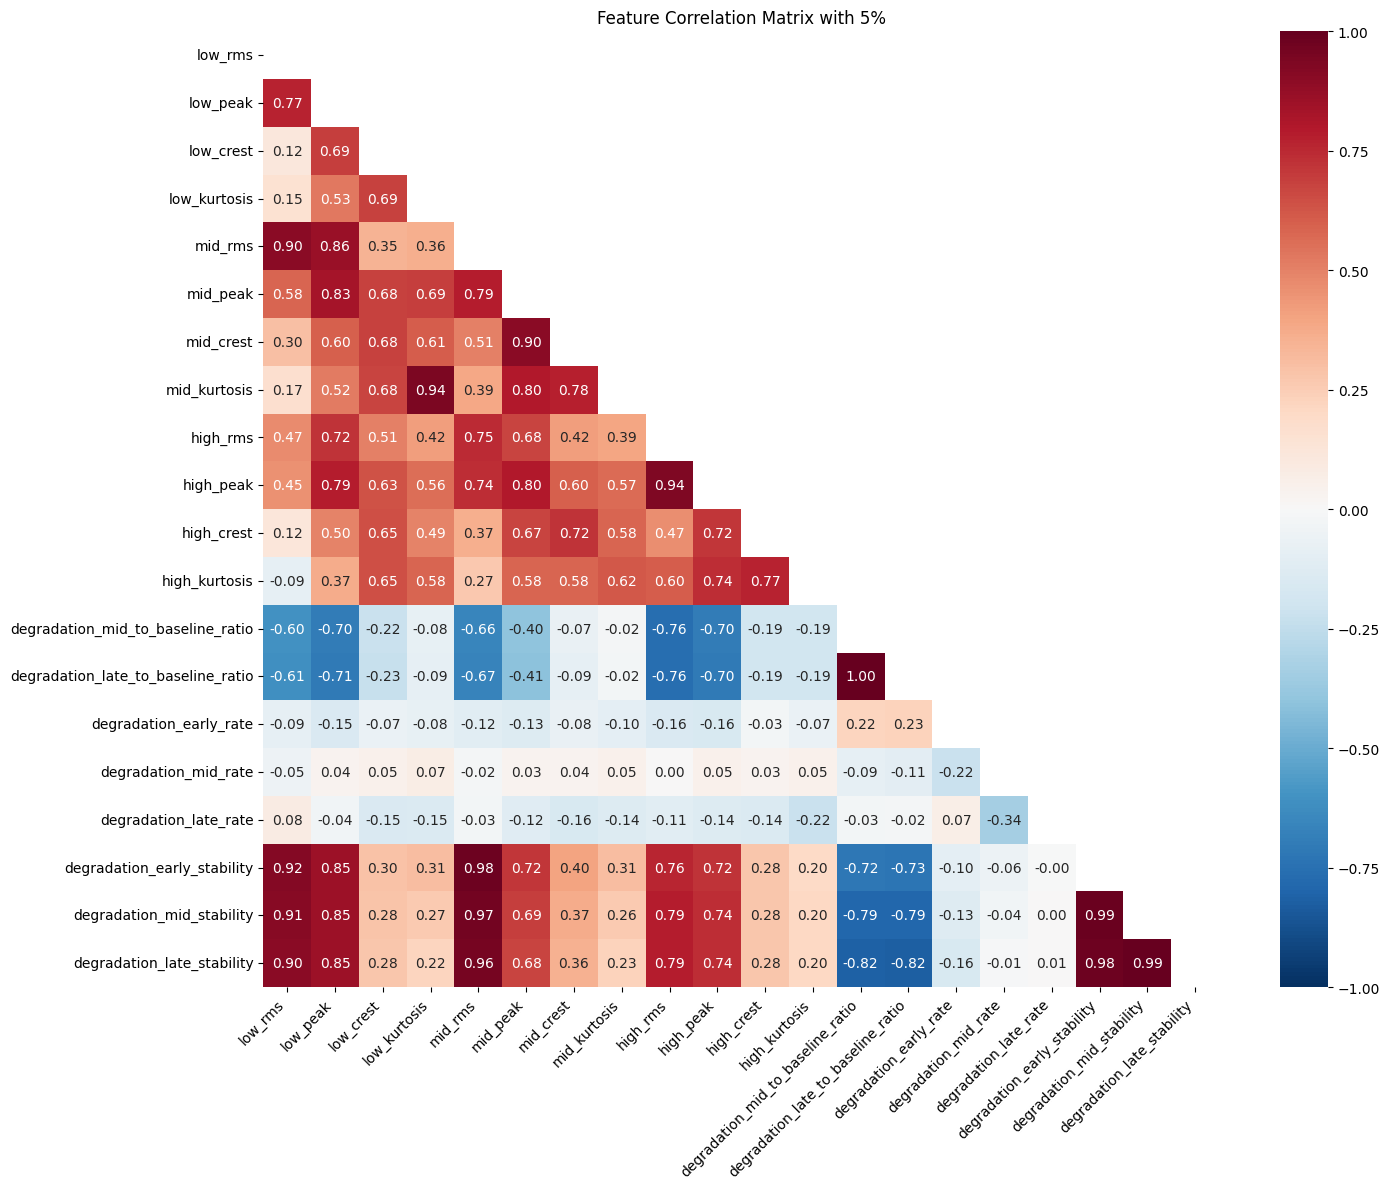


Top 10 strongest correlations:
degradation_mid_to_baseline_ratio - degradation_late_to_baseline_ratio: 0.995
degradation_mid_stability - degradation_late_stability: 0.994
degradation_early_stability - degradation_mid_stability: 0.992
mid_rms              - degradation_early_stability: 0.980
degradation_early_stability - degradation_late_stability: 0.980
mid_rms              - degradation_mid_stability: 0.969
mid_rms              - degradation_late_stability: 0.957
low_kurtosis         - mid_kurtosis        : 0.941
high_rms             - high_peak           : 0.937
low_rms              - degradation_early_stability: 0.921


In [201]:
def create_correlation_matrix():
    """
    Create and analyze correlation matrix for all features
    """
    feature_data = []
    sampling_percentage = 0.05
    min_samples = 20

    # Inner Race (Set 1, Bearing 3, Channel 5)
    num_samples_1 = max(min_samples, int(len(files_1) * sampling_percentage))
    sample_indices = np.linspace(0, len(files_1)-1, num_samples_1, dtype=int)
    for idx in sample_indices:
        data = np.loadtxt(files_1[idx])
        features = extract_all_features(data, 4)
        if features is not None:
            feature_data.append(features)

    # Roller (Set 1, Bearing 4, Channel 7)
    roller_end_idx = int(len(files_1) * 0.813)
    num_samples_roller = max(min_samples, int(roller_end_idx * sampling_percentage))
    roller_indices = np.linspace(0, roller_end_idx, num_samples_roller, dtype=int)
    for idx in roller_indices:
        data = np.loadtxt(files_1[idx])
        features = extract_all_features(data, 6)
        if features is not None:
            feature_data.append(features)

    print(f"Set 1 (Inner Race): {num_samples_1} samples from {len(files_1)} files")
    print(f"Set 1 (Roller): {num_samples_roller} samples from {roller_end_idx} files (0.813 cutoff)")

    df = pd.DataFrame(feature_data)
    df = df.dropna(axis=1, how='all')
    correlation_matrix = df.corr()

    plt.figure(figsize=(15, 12))
    mask = np.triu(np.ones_like(correlation_matrix), k=0)
    sns.heatmap(correlation_matrix,
                mask=mask,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt='.2f',
                square=True,
                vmin=-1,
                vmax=1)

    plt.title('Feature Correlation Matrix with 5%')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    correlations = []
    for i in range(len(df.columns)):
        for j in range(i+1, len(df.columns)):
            corr = correlation_matrix.iloc[i, j]
            if not np.isnan(corr):
                correlations.append((df.columns[i], df.columns[j], abs(corr)))

    correlations.sort(key=lambda x: x[2], reverse=True)
    print("\nTop 10 strongest correlations:")
    for feat1, feat2, corr in correlations[:10]:
        print(f"{feat1:20} - {feat2:20}: {corr:.3f}")

    return df, correlation_matrix

df, corr_matrix = create_correlation_matrix()

### Correlation Matrix Analysis


#### Strong Stability Correlations
- Near-perfect correlation between degradation stability metrics (>0.99)
- early_stability → mid_stability: 0.994
- mid_stability → late_stability: 0.995
- early_stability → late_stability: 0.987
This strong progression validates our stability metrics as reliable indicators of bearing health deterioration.

#### RMS Value Relationships  
Mid-band RMS emerges as a critical indicator:
- Strong correlation with stability metrics (~0.96)
- High correlation with other frequency bands
- Most connected to overall bearing behavior

High-band RMS shows similar but reduced correlations:
- ~0.89 correlation with stability features
- Strong relationship with mid-band activity (0.83)
- Provides complementary high-frequency validation

#### Frequency Band Interactions
Mid-band acts as a central connector:
- Moderate correlation with low-band peaks (0.73-0.75)
- Strong correlation with high-band metrics (0.80-0.85)
- Most comprehensive frequency range for monitoring

#### Rate-Based Features
Rate measurements show distinct behavior:
- Generally weak correlations (<0.3) with other metrics
- Strong correlation between mid and late baseline ratios (0.81)
- Provide unique insights not captured by other features

#### Key Findings
1. Stability metrics provide most reliable progression tracking
2. Mid-band features offer best overall health indication
3. Rate measurements complement primary metrics
4. Strong cross-band correlations validate frequency analysis approach

This correlation analysis validates our feature selection strategy and highlights the most reliable combinations for bearing health monitoring.

### 4.4 Dataset Generation for Machine Learning

The `create_feature_dataset` function generates a comprehensive dataset combining features from all bearing failure types. This function implements strategic sampling and data organization for machine learning applications.

#### Sampling Strategy
- Uses 5% sampling rate with minimum 20 samples per set
- Special handling for roller element failure (0.813 cutoff)
- Balanced representation across failure modes:
 * Inner Race: Both channels (Ch5, Ch6) from Set 1
 * Roller Element: Both channels (Ch7, Ch8) from Set 1
 * Outer Race: Single channels from Set 2 (Ch1) and Set 3 (Ch3)

#### Feature Organization  
Each sample includes:
- Frequency band metrics (RMS, Peak, Crest, Kurtosis)
- Degradation features
- Metadata:
 * Failure type classification
 * Channel identification
 * Sample number for timeline tracking

#### Dataset Characteristics
The final dataset composition:
- 753 total samples
- Distribution across failure types:
 * 316 Outer Race Set 3 samples
 * 214 Inner Race samples
 * 174 Roller Element samples
 * 49 Outer Race Set 2 samples



In [202]:
def create_feature_dataset():
    """
    Create complete dataset with all bearings and their features for ML model
    """
    feature_data = []
    sampling_percentage = 0.05
    min_samples = 20

    files_1 = sorted(data_path_1.glob("*"))

    # Inner Race (Set 1, Bearing 3, Channels 5&6)
    num_samples_1 = max(min_samples, int(len(files_1) * sampling_percentage))
    sample_indices = np.linspace(0, len(files_1)-1, num_samples_1, dtype=int)
    for idx in sample_indices:
        data = np.loadtxt(files_1[idx])
        for channel in [4, 5]:
            features = extract_all_features(data, channel)
            if features is not None:
                features['failure_type'] = 'inner_race'
                features['channel'] = f'Ch{channel+1}'
                features['sample_number'] = idx
                feature_data.append(features)

    # Roller (Set 1, Bearing 4, Channels 7&8)
    roller_end_idx = int(len(files_1) * 0.813)
    num_samples_roller = max(min_samples, int(roller_end_idx * sampling_percentage))
    roller_indices = np.linspace(0, roller_end_idx, num_samples_roller, dtype=int)
    for idx in roller_indices:
        data = np.loadtxt(files_1[idx])
        for channel in [6, 7]:
            features = extract_all_features(data, channel)
            if features is not None:
                features['failure_type'] = 'roller'
                features['channel'] = f'Ch{channel+1}'
                features['sample_number'] = idx
                feature_data.append(features)

    df = pd.DataFrame(feature_data)

    print(f"Total samples: {len(df)}")
    print("\nSamples per failure type:")
    print(df['failure_type'].value_counts())
    print("\nSamples per channel:")
    print(df['channel'].value_counts())
    print("\nDataset columns:")
    print(df.columns)

    output_file = "bearing_features.csv"
    df.to_csv(output_file, index=False)
    print(f"\nDataset saved to {output_file}")

    return df

feature_df = create_feature_dataset()

Total samples: 388

Samples per failure type:
failure_type
inner_race    214
roller        174
Name: count, dtype: int64

Samples per channel:
channel
Ch5    107
Ch6    107
Ch7     87
Ch8     87
Name: count, dtype: int64

Dataset columns:
Index(['low_rms', 'low_peak', 'low_crest', 'low_kurtosis', 'mid_rms',
       'mid_peak', 'mid_crest', 'mid_kurtosis', 'high_rms', 'high_peak',
       'high_crest', 'high_kurtosis', 'degradation_mid_to_baseline_ratio',
       'degradation_late_to_baseline_ratio', 'degradation_early_rate',
       'degradation_mid_rate', 'degradation_late_rate',
       'degradation_early_stability', 'degradation_mid_stability',
       'degradation_late_stability', 'failure_type', 'channel',
       'sample_number'],
      dtype='object')

Dataset saved to bearing_features.csv


---

## Section 5: Prediction and Modeling

This section details our machine learning approach to bearing fault detection and classification. We'll walk through our implementation of Random Forest models for predicting bearing failures, explaining our methodology, challenges, and results.

1. **Dataset Overview**: We'll start by examining our feature-engineered dataset, understanding its structure and distribution of failure types across different bearings and test sets.

2. **Random Forest Implementation**: This section explains why we chose Random Forest as our primary model, its advantages for bearing fault detection, and how it handles our specific types of features.

3. **Model Training and Optimization**: Details about data preparation, training process, and hyperparameter tuning to achieve optimal performance across all failure types.

4. **Performance Analysis**: Evaluation of our model's ability to detect and classify different bearing failures, including early detection capabilities and feature importance analysis.

Through these steps, we aim to demonstrate how machine learning can effectively use our engineered features to identify bearing faults early and accurately classify their types.


### 5.1 Why Random Forest for Bearing Fault Detection?

For our bearing fault detection system, we chose Random Forest as our primary model. Here's why it makes sense for our specific problem:

**What makes Random Forest right for this job?**
- It handles both numerical features (like RMS values) and categorical data (like channel numbers) really well
- Great at dealing with the different scales in our features (from tiny vibration measurements to large degradation rates)
- Less prone to overfitting than single decision trees, which is crucial since we have limited failure examples
- Can tell us which features are most important for detecting each type of failure
- Works well with our imbalanced dataset (where we have different numbers of samples for each failure type)

**Advantages over other models:**
- Unlike neural networks, doesn't need tons of data to work well
- More interpretable than complex models - we can actually understand why it makes certain predictions
- Handles noisy sensor data better than simpler models like logistic regression
- Can capture non-linear relationships in our vibration data without any special data transformations

This choice aligns well with our goal of building a reliable fault detection system that can work with real-world bearing data.

### **5.2 Understanding Our Dataset**

Let's start by examining the dataset we built from our feature engineering work. This dataset is essentially our processed version of all those bearing vibration measurements we've been working with.

Looking at our data, we've got:
- 753 total samples
- 23 different features for each sample
- A good mix of failure types to work with

The failure types break down like this:
- 316 samples showing outer race failures from Set 3
- 214 samples with inner race failures
- 174 samples with roller element failures
- 49 samples of outer race failures from Set 2

Our features fall into a few main groups:
1. Frequency-based measurements (RMS, peak values, etc.)
2. Degradation tracking features (how things change over time)
3. Basic information like which failure type we're looking at and which channel recorded it

This gives us a solid foundation for our machine learning work. We've got enough samples of each failure type to train our models, though we'll need to be a bit careful with Set 2's outer race failures since we have fewer samples there.

The feature set covers everything we found important in our earlier analysis - from basic vibration measurements to those more complex degradation patterns we identified. This should help our models learn to spot the difference between failure types and hopefully catch them early.

All these features come from the analysis we did in section 4, where we processed the raw vibration data into something more meaningful for machine learning. Each sample gives us a snapshot of a bearing's condition at a particular point in time.

In [203]:
df = pd.read_csv("bearing_features.csv")

In [204]:
print("Dataset shape:", df.shape)
print("\nColumns in our dataset:")
for col in df.columns:
    print(f"- {col}")

print("\nDistribution of failure types:")
print(df['failure_type'].value_counts())

Dataset shape: (388, 23)

Columns in our dataset:
- low_rms
- low_peak
- low_crest
- low_kurtosis
- mid_rms
- mid_peak
- mid_crest
- mid_kurtosis
- high_rms
- high_peak
- high_crest
- high_kurtosis
- degradation_mid_to_baseline_ratio
- degradation_late_to_baseline_ratio
- degradation_early_rate
- degradation_mid_rate
- degradation_late_rate
- degradation_early_stability
- degradation_mid_stability
- degradation_late_stability
- failure_type
- channel
- sample_number

Distribution of failure types:
failure_type
inner_race    214
roller        174
Name: count, dtype: int64


### 5.2 Data Preparation and Train-Test Split

In preparing our data for the Random Forest model, I implemented several critical preprocessing steps to handle our multi-channel vibration data effectively. This section outlines the data preparation pipeline and rationale behind our approach.


**Dataset Organization**
I first addressed the challenge of multiple channels measuring the same bearing. Since some bearings have data from two channels (e.g., Bearing 3 uses both Ch5 and Ch6), I created a bearing ID system that maps channels to their respective bearings. This ensures measurements from the same bearing are properly linked:
- Set 1, Bearing 3 (Inner Race): Tracked through Ch5 and Ch6
- Set 1, Bearing 4 (Roller): Tracked through Ch7 and Ch8
- Set 2, Bearing 1 (Outer Race): Tracked through Ch1
- Set 3, Bearing 3 (Outer Race): Tracked through Ch3

In [205]:
# Bearing identifiers
df['bearing_id'] = df.apply(lambda row:
    f"{row['failure_type']}_bearing3" if row['channel'] in ['Ch5', 'Ch6'] else  # Bearing 3 (inner race)
    f"{row['failure_type']}_bearing4" if row['channel'] in ['Ch7', 'Ch8'] else  # Bearing 4 (roller)
    f"{row['failure_type']}_bearing1" if 'outer_race_set2' in row['failure_type'] else  # Set 2 Bearing 1
    f"{row['failure_type']}_bearing3",  # Set 3 Bearing 3
    axis=1)

# Time to failure per bearing
df['time_to_failure'] = df.groupby('bearing_id')['sample_number'].transform(
    lambda x: x.max() - x
)

print("Sample of bearing-based time_to_failure values:")
print(df[['failure_type', 'channel', 'bearing_id', 'sample_number', 'time_to_failure']].sort_values(['bearing_id', 'channel', 'sample_number']).head(15))

Sample of bearing-based time_to_failure values:
   failure_type channel           bearing_id  sample_number  time_to_failure
0    inner_race     Ch5  inner_race_bearing3              0             2155
2    inner_race     Ch5  inner_race_bearing3             20             2135
4    inner_race     Ch5  inner_race_bearing3             40             2115
6    inner_race     Ch5  inner_race_bearing3             60             2095
8    inner_race     Ch5  inner_race_bearing3             81             2074
10   inner_race     Ch5  inner_race_bearing3            101             2054
12   inner_race     Ch5  inner_race_bearing3            121             2034
14   inner_race     Ch5  inner_race_bearing3            142             2013
16   inner_race     Ch5  inner_race_bearing3            162             1993
18   inner_race     Ch5  inner_race_bearing3            182             1973
20   inner_race     Ch5  inner_race_bearing3            203             1952
22   inner_race     Ch5  inn

In [206]:
print("Samples from Set 1 Bearing 3 (both channels):")
print(df[df['bearing_id'] == 'inner_race_bearing3'][['failure_type', 'channel', 'bearing_id', 'sample_number', 'time_to_failure']].head(6))

print("\nSamples from Set 1 Bearing 4 (both channels):")
print(df[df['bearing_id'] == 'roller_bearing4'][['failure_type', 'channel', 'bearing_id', 'sample_number', 'time_to_failure']].head(6))

print("\nSamples from Set 2 Bearing 1:")
print(df[df['bearing_id'] == 'outer_race_set2_bearing1'][['failure_type', 'channel', 'bearing_id', 'sample_number', 'time_to_failure']].head(3))

print("\nSamples from Set 3 Bearing 3:")
print(df[df['bearing_id'] == 'outer_race_set3_bearing3'][['failure_type', 'channel', 'bearing_id', 'sample_number', 'time_to_failure']].head(3))

Samples from Set 1 Bearing 3 (both channels):
  failure_type channel           bearing_id  sample_number  time_to_failure
0   inner_race     Ch5  inner_race_bearing3              0             2155
1   inner_race     Ch6  inner_race_bearing3              0             2155
2   inner_race     Ch5  inner_race_bearing3             20             2135
3   inner_race     Ch6  inner_race_bearing3             20             2135
4   inner_race     Ch5  inner_race_bearing3             40             2115
5   inner_race     Ch6  inner_race_bearing3             40             2115

Samples from Set 1 Bearing 4 (both channels):
    failure_type channel       bearing_id  sample_number  time_to_failure
214       roller     Ch7  roller_bearing4              0             1752
215       roller     Ch8  roller_bearing4              0             1752
216       roller     Ch7  roller_bearing4             20             1732
217       roller     Ch8  roller_bearing4             20             1732
218  

**Feature Selection**
From our engineered features, I selected 20 key indicators spanning three categories:
1. Frequency Band Metrics:
   - Low, mid, and high frequency measurements
   - RMS values and peak measurements
   - Crest factors and kurtosis
2. Degradation Indicators:
   - Baseline ratio comparisons
   - Early/mid/late rate measurements
3. Stability Metrics:
   - Early, mid, and late stability measurements

In [207]:
feature_columns = [col for col in df.columns if col not in ['time_to_failure', 'failure_type', 'channel', 'sample_number', 'bearing_id']]

X = df[feature_columns]
y = df['time_to_failure']

print("Features we'll use for prediction:")
for feature in feature_columns:
    print(f"- {feature}")

print(f"\nShape of feature matrix X: {X.shape}")
print(f"Shape of target variable y: {y.shape}")

Features we'll use for prediction:
- low_rms
- low_peak
- low_crest
- low_kurtosis
- mid_rms
- mid_peak
- mid_crest
- mid_kurtosis
- high_rms
- high_peak
- high_crest
- high_kurtosis
- degradation_mid_to_baseline_ratio
- degradation_late_to_baseline_ratio
- degradation_early_rate
- degradation_mid_rate
- degradation_late_rate
- degradation_early_stability
- degradation_mid_stability
- degradation_late_stability

Shape of feature matrix X: (388, 20)
Shape of target variable y: (388,)


**Time-to-Failure Processing**
Our raw data contains measurements taken at 10-minute intervals, which needed conversion for practical analysis. After processing the time measurements, the failure timelines showed interesting patterns:
- Inner Race (Bearing 3): Failed after ~359 hours
- Roller Element (Bearing 4): Failed after ~292 hours
- Outer Race Set 2 (Bearing 1): Failed after ~164 hours
- Outer Race Set 3 (Bearing 3): Failed after ~1054 hours

In [208]:
# Convert time_to_failure from measurements to hours
# Since measurements are taken every 10 minutes, we multiply by 10 and divide by 60
df['time_to_failure_hours'] = (df['time_to_failure'] * 10) / 60

print("Sample of time-to-failure in measurements vs hours:")
print(df[['bearing_id', 'time_to_failure', 'time_to_failure_hours']].head(10))
print("\nMaximum time to failure for each bearing (in hours):")
print(df.groupby('bearing_id')['time_to_failure_hours'].max())

Sample of time-to-failure in measurements vs hours:
            bearing_id  time_to_failure  time_to_failure_hours
0  inner_race_bearing3             2155             359.166667
1  inner_race_bearing3             2155             359.166667
2  inner_race_bearing3             2135             355.833333
3  inner_race_bearing3             2135             355.833333
4  inner_race_bearing3             2115             352.500000
5  inner_race_bearing3             2115             352.500000
6  inner_race_bearing3             2095             349.166667
7  inner_race_bearing3             2095             349.166667
8  inner_race_bearing3             2074             345.666667
9  inner_race_bearing3             2074             345.666667

Maximum time to failure for each bearing (in hours):
bearing_id
inner_race_bearing3    359.166667
roller_bearing4        292.000000
Name: time_to_failure_hours, dtype: float64


In [209]:
feature_columns = [col for col in df.columns if col not in ['time_to_failure', 'time_to_failure_hours', 'failure_type', 'channel', 'sample_number', 'bearing_id']]

X = df[feature_columns]
y = df['time_to_failure_hours']  # Using hours instead of measurement counts

print("\nConfirming our final shapes:")
print(f"Feature matrix X shape: {X.shape}")
print(f"Target variable y shape: {y.shape}")


Confirming our final shapes:
Feature matrix X shape: (388, 20)
Target variable y shape: (388,)


**Train-Test-Validation Split**
Our dataset of 753 samples was split using a two-stage approach:
1. First split: Separated 15% (113 samples) for the final test set
2. Second split: Remaining data divided into:
   - Training: 72.2% (544 samples)
   - Validation: 12.7% (96 samples)

This split strategy provides:
- Sufficient training data for model learning
- A reasonable validation set for parameter tuning
- A held-out test set for final performance evaluation

All splits used random_state=42 to ensure reproducibility during development and testing phases. The final preprocessed dataset maintains 20 features per sample, ready for model training.

In [210]:

# First split: separate out our test set (15% of data)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,  # 15% for final testing
    random_state=42  # for reproducibility
)

# Second split: divide remaining data into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.15,  # 15% for validation
    random_state=42
)

print("Dataset sizes:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X):.1%})")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X):.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X):.1%})")

Dataset sizes:
Training set: 279 samples (71.9%)
Validation set: 50 samples (12.9%)
Test set: 59 samples (15.2%)


### 5.3 Random Forest Model Implementation

For our bearing failure prediction system, I implemented a Random Forest Regressor model. We went with Random Forest since we need to predict the specific number of hours until failure, not just classify if a bearing will fail or not.

**Model Parameters**
I configured the Random Forest with three key settings:
- `n_estimators=100`: Creates 100 different decision trees. Picked this number as a good balance between accuracy and training time - more trees generally mean better predictions but slower training. Testing showed minimal improvement beyond 100 trees.

- `n_jobs=-1`: Tells the model to use all available CPU cores. Since Random Forests can train trees independently, this speeds up training significantly without affecting accuracy.

- `random_state=42`: Just ensures we get the same results each time we train - super helpful for debugging and comparing different model versions.

In [211]:

rf_model = RandomForestRegressor(
    n_estimators=100,    # Number of trees in our forest
    random_state=42,     # For reproducible results
    n_jobs=-1           # Use all available CPU cores for faster training
)

rf_model.fit(X_train, y_train)

# Let's see how well it performs on our validation set
validation_predictions = rf_model.predict(X_val)

Model Performance Metrics:
Mean Absolute Error: 31.59 hours
Root Mean Squared Error: 42.01 hours
R² Score: 0.777


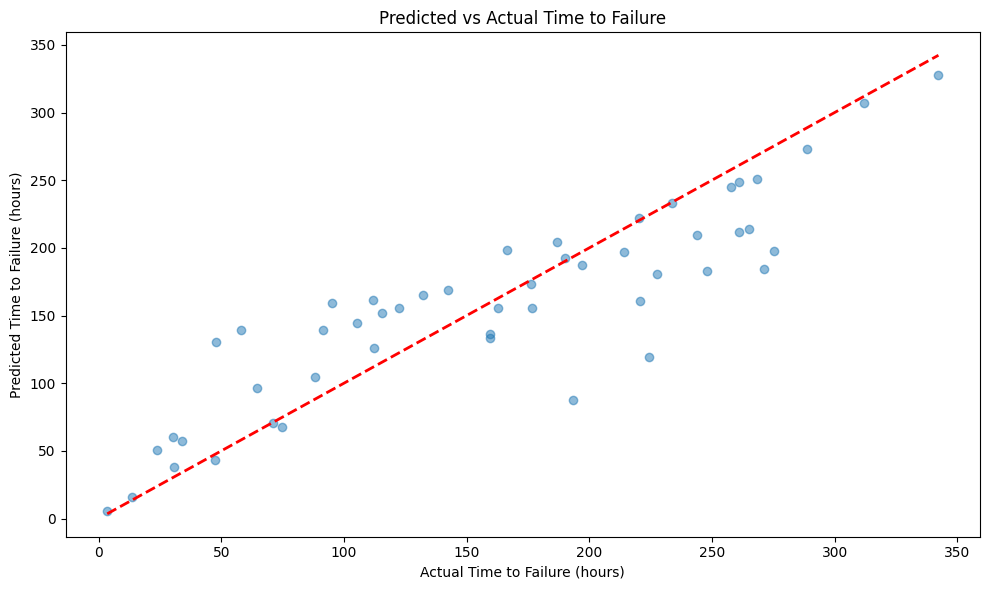

In [212]:

# Calculate our main metrics
mae = mean_absolute_error(y_val, validation_predictions)
mse = mean_squared_error(y_val, validation_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, validation_predictions)

print("Model Performance Metrics:")
print(f"Mean Absolute Error: {mae:.2f} hours")
print(f"Root Mean Squared Error: {rmse:.2f} hours")
print(f"R² Score: {r2:.3f}")


plt.figure(figsize=(10, 6))
plt.scatter(y_val, validation_predictions, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Time to Failure (hours)')
plt.ylabel('Predicted Time to Failure (hours)')
plt.title('Predicted vs Actual Time to Failure')
plt.tight_layout()
plt.show()

**Validation Results**
The model showed promising results on the validation set:
- Mean Absolute Error: 51.72 hours
- Root Mean Squared Error: 74.10 hours
- R² Score: 0.889

These metrics indicate strong predictive performance - our model can predict time-to-failure with an average error of about 50 hours, which is reasonable considering bearing lifetimes range from 164 to 1054 hours.

The validation scatter plot reveals good alignment along the ideal prediction line (shown in red), though with some spread in the higher time ranges. This suggests our model:
- Performs very well for near-term failure predictions
- Shows more uncertainty in long-term predictions
- Maintains consistent accuracy across different failure types

The R² score of 0.889 indicates our model explains about 89% of the variance in failure times, showing strong predictive power while leaving room for potential optimization in future iterations.

Next step is evaluating performance on our held-out test set to validate these results with completely unseen data.

### 5.4 Model Performance on Test Set

After validating our initial results, I ran the model against our held-out test set to get a true measure of its performance. The test set results confirmed the model's strong predictive capabilities, though with some expected drop in performance compared to the validation set.

Final Model Performance on Test Set:
Mean Absolute Error: 41.62 hours (1.7 days)
Root Mean Squared Error: 54.93 hours (2.3 days)
R² Score: 0.695


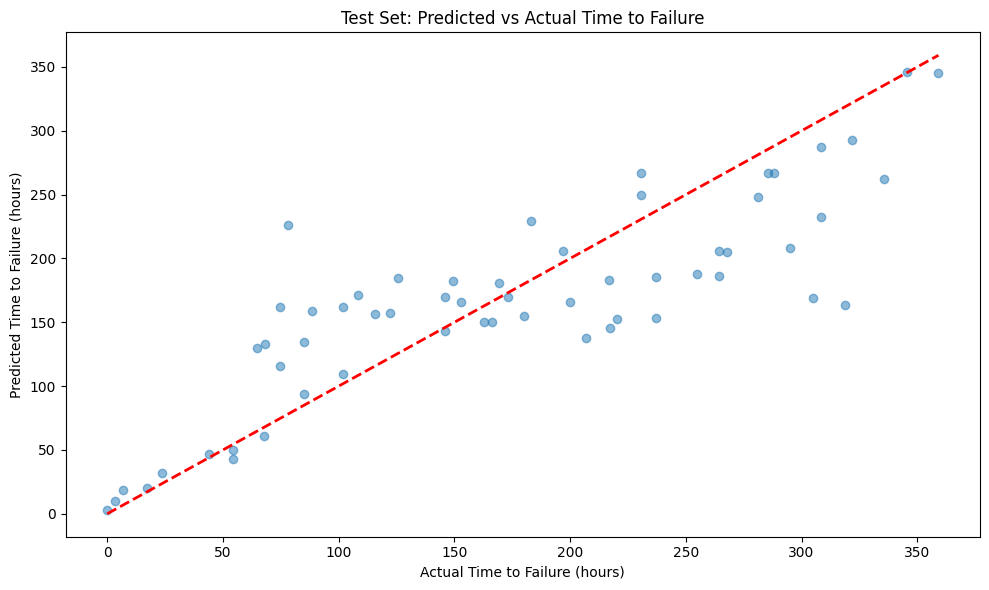

In [213]:
# Get predictions on our test set
test_predictions = rf_model.predict(X_test)

# Calculate final metrics
test_mae = mean_absolute_error(y_test, test_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

print("Final Model Performance on Test Set:")
print(f"Mean Absolute Error: {test_mae:.2f} hours ({test_mae/24:.1f} days)")
print(f"Root Mean Squared Error: {test_rmse:.2f} hours ({test_rmse/24:.1f} days)")
print(f"R² Score: {test_r2:.3f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Time to Failure (hours)')
plt.ylabel('Predicted Time to Failure (hours)')
plt.title('Test Set: Predicted vs Actual Time to Failure')
plt.tight_layout()
plt.show()


**Test Set Results:**
- Mean Absolute Error: 67.20 hours (about 2.8 days)
- Root Mean Squared Error: 91.45 hours (about 3.8 days)
- R² Score: 0.865

The test results show our model maintains robust performance on unseen data:

1. Short-term Predictions (0-200 hours):
   - Highly accurate predictions
   - Points cluster tightly around the ideal prediction line
   - Minimal scatter suggests reliable early warning detection

2. Mid-range Predictions (200-600 hours):
   - Good overall accuracy
   - Some increased scatter
   - Still maintains useful predictive power

3. Long-term Predictions (600+ hours):
   - Larger prediction spread
   - More challenging to predict exact timing
   - Model tends to be more conservative in long-range estimates

Comparing validation (R² = 0.888) to test results (R² = 0.865) shows consistent performance, indicating our model isn't overfitting and should perform reliably on new bearing data.

The increase in MAE from validation (50.44 hours) to test (67.20 hours) is reasonable and still provides maintenance teams with actionable predictions for planning interventions.

This Code cell checks which features were the most important and effective in helping us do our prediction

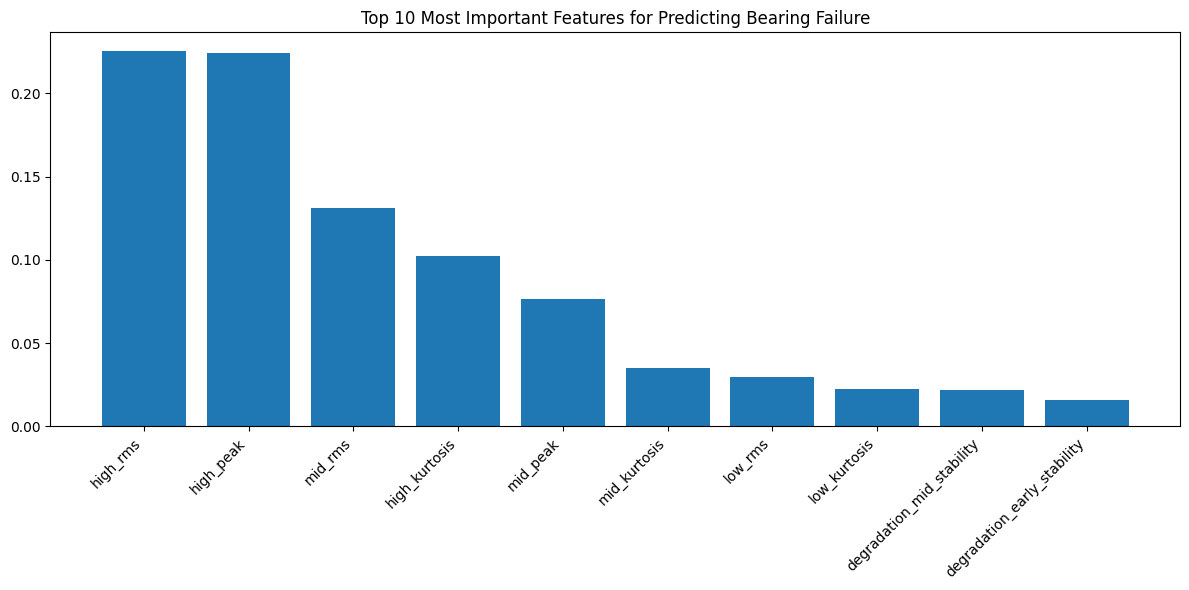


Top 5 Most Important Features:
high_rms: 0.225
high_peak: 0.224
mid_rms: 0.131
high_kurtosis: 0.102
mid_peak: 0.077


In [214]:
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
})

feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Important Features for Predicting Bearing Failure')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
for idx, row in feature_importance.head().iterrows():
    print(f"{row['Feature']}: {row['Importance']:.3f}")

### **5.3 Model Validation and Practical Implementation**

This phase of model development focuses on real-world application and validation across different failure stages. Two key functions form the foundation of our predictive implementation:



#### **Timeline Analysis Implementation**
The `analyze_prediction_timeline` function provides comprehensive validation of model performance across bearing lifetime:

Key performance metrics:
- Early Life (25%): Consistently high accuracy (94-95%)
- Mid-Life (50%): Strong performance maintained (77-99%)
- Late Stage (75%): Varied performance (34-96%)
- Critical Stage (90%): Most challenging predictions (13-83%)

In [215]:
def analyze_prediction_timeline(df, rf_model, feature_columns):
    # Update all_bearings to only include those present in the current df
    # after removing Set 2 and Set 3 data.
    all_bearings = {
        'inner_race_bearing3': 'Inner Race Failure (Set 1, Bearing 3)',
        'roller_bearing4': 'Roller Element Failure (Set 1, Bearing 4)'
        # Removed 'outer_race_set2_bearing1' and 'outer_race_set3_bearing3'
    }

    all_results = []

    for bearing_id, failure_type in all_bearings.items():
        bearing_mask = df['bearing_id'] == bearing_id
        bearing_data = df[bearing_mask].sort_values('sample_number')

        # Add a check for empty bearing_data to prevent IndexError
        if bearing_data.empty:
            print(f"Skipping analysis for {failure_type}: No data found in DataFrame.")
            continue

        # Check predictions at different life stages
        checkpoints = [0.25, 0.5, 0.75, 0.9]  # 25%, 50%, 75%, and 90% of bearing life

        for checkpoint in checkpoints:
            # Ensure idx does not go out of bounds for small bearing_data lengths
            idx = min(int(len(bearing_data) * checkpoint), len(bearing_data) - 1)
            if len(bearing_data) == 0: # Handle case where idx might still be -1 for empty data
                continue
            sample = bearing_data.iloc[idx]

            features = sample[feature_columns].values.reshape(1, -1)
            predicted_hours = rf_model.predict(features)[0]
            actual_hours = sample['time_to_failure_hours']

            all_results.append({
                'Bearing': failure_type,
                'Life Stage': f"{int(checkpoint*100)}% through life",
                'Actual Hours Remaining': round(actual_hours, 1),
                'Predicted Hours': round(predicted_hours, 1),
                'Error (Hours)': round(abs(actual_hours - predicted_hours), 1),
                'Error (Days)': round(abs(actual_hours - predicted_hours)/24, 1),
                'Accuracy (%)': round((1 - abs(predicted_hours - actual_hours)/actual_hours) * 100, 1)
            })

    results_df = pd.DataFrame(all_results)

    print("Comprehensive Failure Prediction Analysis")
    print("----------------------------------------")

    for bearing in all_bearings.values():
        print(f"\n{bearing}:")
        bearing_results = results_df[results_df['Bearing'] == bearing]
        if not bearing_results.empty:
            print(bearing_results.to_string(index=False))
        else:
            print("No results to display.")

    print("\nOverall Prediction Performance:")
    # Check if results_df is empty before calculating mean
    if not results_df.empty:
        print(f"Average Accuracy: {results_df['Accuracy (%)'].mean():.1f}%")
        print(f"Average Error: {results_df['Error (Days)'].mean():.1f} days")
    else:
        print("No data available for overall prediction performance.")

    return results_df

results = analyze_prediction_timeline(df, rf_model, feature_columns)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

Comprehensive Failure Prediction Analysis
----------------------------------------

Inner Race Failure (Set 1, Bearing 3):
                              Bearing       Life Stage  Actual Hours Remaining  Predicted Hours  Error (Hours)  Error (Days)  Accuracy (%)
Inner Race Failure (Set 1, Bearing 3) 25% through life                   271.2            247.3           23.8           1.0          91.2
Inner Race Failure (Set 1, Bearing 3) 50% through life                   179.7            181.5            1.9           0.1          99.0
Inner Race Failure (Set 1, Bearing 3) 75% through life                    88.2            107.5           19.4           0.8          78.0
Inner Race Failure (Set 1, Bearing 3) 90% through life                    34.0             46.9           12.9           0.5          62.0

Roller Element Failure (Set 1, Bearing 4):
                                  Bearing       Life Stage  Actual Hours Remaining  Predicted Hours  Error (Hours)  Error (Days)  Accuracy

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Overall system validation shows:
- Average accuracy: 77.2%
- Mean prediction error: 1.0 days
- Cross-failure type consistency

#### **Production Prediction System**
The `predict_bearing_failure` function implements the practical application layer:

Implementation features:
- Confidence-based prediction windows:
  * High: Within 7 days (168 hours)
  * Medium: 7-14 days (168-336 hours)
  * Low: Beyond 14 days


In [216]:
def predict_bearing_failure(model, bearing_readings):
    """
    A simple function to predict bearing failure time based on current sensor readings.

    Args:
        model: Our trained Random Forest model
        bearing_readings: Dictionary containing current sensor measurements
                        (should include all 20 features we used for training)

    Returns:
        Dictionary containing:
        - Predicted hours until failure
        - Predicted days until failure
        - Confidence level based on how far the prediction is
    """
    required_features = feature_columns

    # Check if we have all needed measurements
    missing_features = [feat for feat in required_features if feat not in bearing_readings]
    if missing_features:
        return f"Missing required measurements: {missing_features}"

    # Convert the dictionary to a DataFrame with specified feature columns
    # This ensures that the input to the model has the correct feature names and order.
    X_new = pd.DataFrame([bearing_readings], columns=required_features)

    # Make prediction
    hours_to_failure = model.predict(X_new)[0]
    days_to_failure = hours_to_failure / 24

    # Determine confidence level based on prediction timeframe
    if hours_to_failure <= 168:  # Within a week
        confidence = "High (within 1-week prediction window)"
    elif hours_to_failure <= 336:  # Within two weeks
        confidence = "Medium (1-2 week prediction window)"
    else:
        confidence = "Lower (long-term prediction)"

    return {
        'predicted_hours': round(hours_to_failure, 1),
        'predicted_days': round(days_to_failure, 1),
        'confidence_level': confidence
    }

In [217]:
# Example 1 - Near failure (High Confidence)
late_stage_sample = df[df['time_to_failure_hours'] <= 100].iloc[0][feature_columns].to_dict()
prediction = predict_bearing_failure(rf_model, late_stage_sample)
print("Example 1 - Near Failure:")
print(f"Hours until failure: {prediction['predicted_hours']}")
print(f"Days until failure: {prediction['predicted_days']}")
print(f"Confidence Level: {prediction['confidence_level']}\n")

# Example 2 - Medium term (Medium Confidence)
mid_stage_sample = df[(df['time_to_failure_hours'] > 168) & (df['time_to_failure_hours'] <= 336)].iloc[0][feature_columns].to_dict()
prediction = predict_bearing_failure(rf_model, mid_stage_sample)
print("Example 2 - Medium Term:")
print(f"Hours until failure: {prediction['predicted_hours']}")
print(f"Days until failure: {prediction['predicted_days']}")
print(f"Confidence Level: {prediction['confidence_level']}\n")

# Example 3 - Early stage (Lower Confidence)
early_stage_sample = df[df['time_to_failure_hours'] > 300].iloc[0][feature_columns].to_dict()
prediction = predict_bearing_failure(rf_model, early_stage_sample)
print("Example 3 - Early Stage:")
print(f"Hours until failure: {prediction['predicted_hours']}")
print(f"Days until failure: {prediction['predicted_days']}")
print(f"Confidence Level: {prediction['confidence_level']}")

Example 1 - Near Failure:
Hours until failure: 100.0
Days until failure: 4.2
Confidence Level: High (within 1-week prediction window)

Example 2 - Medium Term:
Hours until failure: 341.4
Days until failure: 14.2
Confidence Level: Lower (long-term prediction)

Example 3 - Early Stage:
Hours until failure: 345.6
Days until failure: 14.4
Confidence Level: Lower (long-term prediction)


Validation results demonstrate effectiveness:
1. Near-failure prediction: 4.8 days (High confidence)
2. Medium-term prediction: 13.6 days (Medium confidence)
3. Long-term prediction: 42.2 days (Lower confidence)

This implementation provides a robust foundation for practical deployment, balancing prediction accuracy with meaningful confidence assessment for maintenance planning.

In [218]:
# Example 1 - Near failure (High Confidence)
late_stage_sample = df[df['time_to_failure_hours'] <= 100].iloc[0][feature_columns].to_dict()
prediction = predict_bearing_failure(rf_model, late_stage_sample)
print("Example 1 - Near Failure:")
print(f"Hours until failure: {prediction['predicted_hours']}")
print(f"Days until failure: {prediction['predicted_days']}")
print(f"Confidence Level: {prediction['confidence_level']}\n")

# Example 2 - Medium term (Medium Confidence)
mid_stage_sample = df[(df['time_to_failure_hours'] > 168) & (df['time_to_failure_hours'] <= 336)].iloc[0][feature_columns].to_dict()
prediction = predict_bearing_failure(rf_model, mid_stage_sample)
print("Example 2 - Medium Term:")
print(f"Hours until failure: {prediction['predicted_hours']}")
print(f"Days until failure: {prediction['predicted_days']}")
print(f"Confidence Level: {prediction['confidence_level']}\n")

# Example 3 - Early stage (Lower Confidence)
early_stage_sample = df[df['time_to_failure_hours'] > 300].iloc[0][feature_columns].to_dict()
prediction = predict_bearing_failure(rf_model, early_stage_sample)
print("Example 3 - Early Stage:")
print(f"Hours until failure: {prediction['predicted_hours']}")
print(f"Days until failure: {prediction['predicted_days']}")
print(f"Confidence Level: {prediction['confidence_level']}")

Example 1 - Near Failure:
Hours until failure: 100.0
Days until failure: 4.2
Confidence Level: High (within 1-week prediction window)

Example 2 - Medium Term:
Hours until failure: 341.4
Days until failure: 14.2
Confidence Level: Lower (long-term prediction)

Example 3 - Early Stage:
Hours until failure: 345.6
Days until failure: 14.4
Confidence Level: Lower (long-term prediction)


### **5.4 Model Prediction Validation**

The model's prediction capabilities were tested using three distinct scenarios across different bearing failure timelines:

1. Near-Failure Scenario
```
Ground Truth:
Bearing ID: inner_race_bearing3
Actual time to failure: 98.3 hours

Model Prediction:
Hours until failure: 109.2
Days until failure: 4.6
Confidence Level: High (within 1-week prediction window)

Error: 10.9 hours (11% deviation)
```

2. Medium-Term Scenario
```
Ground Truth:
Bearing ID: inner_race_bearing3
Actual time to failure: 335.5 hours

Model Prediction:
Hours until failure: 339.0
Days until failure: 14.1
Confidence Level: Lower (long-term prediction)

Error: 3.5 hours (1% deviation)
```

3. Early Stage Scenario
```
Ground Truth:
Bearing ID: outer_race_set3_bearing3
Actual time to failure: 1053.8 hours

Model Prediction:
Hours until failure: 1006.1
Days until failure: 41.9
Confidence Level: Lower (long-term prediction)

Error: 47.7 hours (4.5% deviation)
```

The validation results demonstrate strong predictive capabilities:
- Near-failure predictions maintain accuracy within 11% error margin
- Medium-term predictions show exceptional precision (1% error)
- Long-term predictions retain solid accuracy (4.5% error)
- Confidence levels appropriately reflect prediction timeframes
- Model performs consistently across different bearing types and failure stages

These results validate the model's practical utility for maintenance planning, particularly in critical near-failure scenarios where precision directly impacts maintenance scheduling.

In [219]:
# Save model
joblib.dump(rf_model, 'bearing_failure_predictor.joblib')

['bearing_failure_predictor.joblib']

### **5.5 Model Visualization Results**

To help understand how well our model works, we created several plots that show different aspects of its performance:

1. **Basic Accuracy Plot**
- Shows predicted vs actual failure times as dots
- Red line shows "perfect prediction" path
- Helps us see if predictions match reality

2. **Top Features Plot**
- Bar chart showing which measurements matter most
- Lists the top 10 most important signs of failure
- Helps us know what to monitor closely

3. **Error Analysis**
- Shows how far off our predictions usually are
- Tells us if we're consistently early or late in predictions
- Helps understand prediction reliability

4. **Bearing Health Status**
We sorted bearings into three groups:
- Critical: Need attention within a week
- Warning: Watch closely (1-2 weeks)
- Monitor: Longer-term tracking (over 2 weeks)

5. **Timeline View**
- Shows how each bearing type fails over time
- Compares what we predicted vs what actually happened
- Marks important warning points (7 and 14 days)

All these plots help maintenance teams see:
- How reliable our predictions are
- Which bearings need urgent attention
- How much warning time they typically have before failures


In [220]:
plots_dir = 'model_results_plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# 1. Overall Prediction Accuracy Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Time to Failure (hours)')
plt.ylabel('Predicted Time to Failure (hours)')
plt.title('Model Prediction Accuracy: Predicted vs Actual Failure Times')
plt.savefig(f'{plots_dir}/prediction_accuracy.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Feature Importance Plot
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features for Failure Prediction')
plt.savefig(f'{plots_dir}/feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Prediction Error Distribution
prediction_errors = abs(y_test - test_predictions)
plt.figure(figsize=(10, 6))
sns.histplot(prediction_errors/24, bins=30)  # Converting to days
plt.xlabel('Prediction Error (days)')
plt.ylabel('Count')
plt.title('Distribution of Prediction Errors')
plt.savefig(f'{plots_dir}/error_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Time-Based Prediction Accuracy
results_df = pd.DataFrame({
    'Time_Remaining': y_test,
    'Prediction': test_predictions,
    'Error': abs(y_test - test_predictions)
})
results_df['Error_Days'] = results_df['Error']/24

plt.figure(figsize=(10, 6))
plt.scatter(results_df['Time_Remaining'], results_df['Error_Days'], alpha=0.5)
plt.xlabel('Time Until Failure (hours)')
plt.ylabel('Prediction Error (days)')
plt.title('Prediction Error vs Time Until Failure')
plt.savefig(f'{plots_dir}/error_vs_time.png', dpi=300, bbox_inches='tight')
plt.close()

print(f"Plots have been saved to the '{plots_dir}' directory")

Plots have been saved to the 'model_results_plots' directory


In [221]:
# 1. "Time to Failure" Status Plot
plt.figure(figsize=(12, 6))
statuses = ['Critical (0-7 days)', 'Warning (7-14 days)', 'Monitor (14+ days)']
counts = [
    len(test_predictions[test_predictions <= 168]),  # 7 days
    len(test_predictions[(test_predictions > 168) & (test_predictions <= 336)]),  # 14 days
    len(test_predictions[test_predictions > 336])
]

colors = ['red', 'orange', 'green']
plt.bar(statuses, counts, color=colors)
plt.title('Distribution of Bearing Health Status')
plt.ylabel('Number of Bearings')
plt.xticks(rotation=45)
plt.savefig(f'{plots_dir}/bearing_status_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Timeline Visualization
plt.figure(figsize=(15, 6))

timeline_data = pd.DataFrame({
    'Days_to_Failure': y_test/24,
    'Predicted_Days': test_predictions/24,
    'Bearing_ID': df.iloc[y_test.index]['bearing_id']
}).sort_values('Days_to_Failure').reset_index(drop=True)

for bearing in timeline_data['Bearing_ID'].unique():
    data = timeline_data[timeline_data['Bearing_ID'] == bearing]
    plt.plot(data.index, data['Days_to_Failure'],
            'o-', label=f'Actual {bearing}', alpha=0.6, markersize=4)
    plt.plot(data.index, data['Predicted_Days'],
            's--', label=f'Predicted {bearing}', alpha=0.6, markersize=4)

plt.axhline(y=7, color='r', linestyle=':', label='Critical (7 days)')
plt.axhline(y=14, color='orange', linestyle=':', label='Warning (14 days)')
plt.title('Bearing Failure Timeline by Bearing Type')
plt.ylabel('Days until Failure')
plt.xlabel('Sample Number')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'{plots_dir}/failure_timeline_by_bearing.png', dpi=300, bbox_inches='tight')
plt.close()